In [1]:
import numpy as np
import pandas as pd

from scipy import stats, special, spatial
from statsmodels.stats.multitest import multipletests
from statsmodels import robust

import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import warnings
warnings.filterwarnings('ignore')

import subprocess, os
import argparse
import itertools
import time

# https://github.com/jnothman/UpSetPlot
import upsetplot


In [2]:
## datasets
folder = '../data/'

# Dataset
# data relevance
fn0 = 'scerevisiae_tpm_full_cut5.csv'
fn1 = 'relevance_rsd1_lmbda022_w10.reg_cf'
fn2 = 'relevance_rsd1_lmbda022_w10.regions'
fn3 = 'scerevisiae.rsd1.lmbda_22.npz'
# Relevance cluster information
fn4 = 'consensus_gene_clusters_4.csv'

# Dataset
# sequences, motifs, rules dframes 
fn10 = 'seqs_z2_08_k4_c6.csv'
fn11 = 'motifs_z2_08_k4_c6.csv'
fn12 = 'rules_z2_08_k4_c6_s3_c001.csv'
fn13 = 'motifs_rsd1_lmbda022_w10_z2'

folder2 = 'tomtom_jaspar-fungi_08_trimmed/'
fn14 = 'jaspar2018_ids.csv'

In [3]:
# def some variables
names = ['0_promoter','1_5UTR','2_3UTR','3_terminator']
limits = np.array([[0,1000],[1000,1300],[1300,1650],[1650,2150]])
names_plot = ['Promoter','5UTR','3UTR','Terminator']
label_names =["0_none", "1_low", "2_medium", "3_high"]
window = 10
lmbda = 0.22


In [4]:
# functions

def boxtpm(x, lmbda):
    return special.inv_boxcox(x, lmbda)

def dframe_stack_list(ins,col,typ='float32'):
    df = ins.copy(deep=True)
    s = df[col].apply(lambda x: pd.Series(list(x)),1).stack().astype(typ)
    s.index = s.index.droplevel(-1)
    s.name = col
    del df[col]
    df = df.join(s)
    return df

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

def fix_strings_list(x):
    return [xxx for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')).replace('[','').replace(']','') for xx in list(x.split(','))] if len(xxx)>0]

def fix_strings_list_space(x):
    return [xxx for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')).replace('[','').replace(']','') for xx in list(x.split(' '))] if len(xxx)>0]

def fix_float_list_comma(x):
    return [float(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace('[','').replace(']','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0]

def fix_float_list_space(x):
    return [float(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace('[','').replace(']','')) for xx in list(x.split(' '))] if len(xxx)>0] #.replace(' ',''))

def fix_int_list(x):
    return [int(xxx) for xxx in [str(xx.replace("'","").replace('.','').replace(' ','')).replace('[','').replace(']','') for xx in list(x.split(' '))] if len(xxx)>0]

def fix_int_list_comma(x):
    return [int(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace('[','').replace(']','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0]

def fix_strings_tuple(x):
    return tuple([xxx for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0])

def fix_int_tuple(x):
    return tuple([int(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0])

def load_data(fname):
    # X is multi-variable array
    # Y contains single variable - fix shape for Keras

    npzfile = np.load(fname)
    Xh_train = npzfile['arr_0']
    Xh_test = npzfile['arr_1']
    Xv_train = npzfile['arr_2'][:,8:]
    Xv_test = npzfile['arr_3'][:,8:]
    Y_train = npzfile['arr_4']
    Y_test = npzfile['arr_5']
    names_train = npzfile['arr_6']
    names_test = npzfile['arr_7']

    X_train = list()
    X_train.append(Xh_train)
    #X_train.append(Xv_train)
    X_test = list()
    X_test.append(Xh_test)
    #X_test.append(Xv_test)

    Y_train = Y_train.astype(np.float32).reshape((-1,))
    Y_test = Y_test.astype(np.float32).reshape((-1,))

    return (np.concatenate((Y_train, Y_test)), 
            np.concatenate((names_train,names_test)), 
            np.concatenate((Xv_train,Xv_test)))

def draw_upset_plot(df_rules):
    dataupset1 = df_rules.groupby('items_regions')['itemset'].count()
    dataupset2 = df_rules.groupby('items_regions')['num_genes'].apply(np.median)
    dataupset = pd.concat([dataupset1,dataupset2],axis=1).reset_index()

    df_rules.reset_index(inplace=True)
    data_upset = upsetplot.from_memberships(dataupset.items_regions.values,data = dataupset[['itemset','num_genes','index']].values)
    data_upset = pd.DataFrame(data_upset)
    data_upset.columns = ['num_rules','avg_genes']
    data_upset
    
    # SUM OVER
    # #upsetplot.plot(data_upset, sum_over='sum_over')
    upset = upsetplot.UpSet(data_upset, sum_over='num_rules', intersection_plot_elements=3)
    #upset.add_catplot(value='num_rules', kind='strip', color='blue')
    upset.plot()
    ax = plt.gca()
    ax.set_ylabel('Num. rules')
    ax.set_yscale('log')
    return data_upset
    
def pariwise_pval(dfp,col1,col2):
    pval = []
    for i in range(len(dfp[col1].unique())):
        for j in range(i+1,len(dfp[col1].unique())):
            xx = dfp[dfp[col1]==dfp[col1].unique()[i]][col2]
            yy = dfp[dfp[col1]==dfp[col1].unique()[j]][col2]
            #tmp = stats.ttest_ind(xx, yy)
            tmp = stats.ranksums(xx, yy)
            pval.append([dfp[col1].unique()[i],dfp[col1].unique()[j],tmp[1]])

    pval = pd.DataFrame(pval,columns=['model_x','model_y','pval'])
    return pval

def between_pval(dfp,col1,col2,col3,test):
    pval = []
    for i in range(len(dfp[col1].unique())):
        xx = dfp[dfp[col1]==dfp[col1].unique()[i]][col2].values[0]
        yy = dfp[dfp[col1]==dfp[col1].unique()[i]][col3].values[0]
        if test=='var':
            tmp = stats.levene(xx, yy)
        if test=='mean':
            tmp = stats.ranksums(xx, yy)
            #tmp = stats.mannwhitneyu(xx, yy)
        pval.append([dfp[col1].unique()[i],tmp[1]])

    pval = pd.DataFrame(pval,columns=[col1,'pval'])
    return pval

def filter_motifs(df_motifs, rules_sig):
    return (df_motifs
            .iloc[np.unique(np.array([element-1 for tupl in rules_sig.itemset.values for element in tupl]))]
            .reset_index())

def filter_genes(df_genes, rules_sig):
    return (df_genes.set_index('gene_id')
            .loc[np.unique(np.array([element for tupl in rules_sig.items_gene_id.values for element in tupl]))]
            .reset_index())

def dynamic_range(x):
    return np.log10(max(x)-min(x))

def signal2noise(x):
    return np.median(x)/np.std(x)

def filter_rules(rules):
    '''removes duplicate itemsets'''
    rules['frozenset'] = rules.itemset.apply(frozenset)
    return (rules.
            sort_values(by='chi_pval') # lowest p-value subsets
            .drop_duplicates(subset=['frozenset'])
           )

def return_significant_rules(rules2, p_cut=0.05):
    # bonf corrected
    rules_bonf = rules2[rules2.chi_pval<p_cut/rules2.shape[0]]
    # BH corrected
    rules = rules2.copy(deep=True)
    rules.sort_values(by=['chi_pval'],inplace=True)
    corr = multipletests(rules.chi_pval.values, alpha=p_cut, method='fdr_bh')
    # uncorrected
    rules_sig = rules2[rules2.chi_pval<p_cut]
    return rules_sig, rules.loc[corr[0]], rules_bonf


# Rules analysis

In [5]:
## load data

# reformat list and set variables

def fix_frame(rules2):
    rules2['itemset'] = rules2.itemset.apply(fix_int_tuple)
    rules2['items_cluster'] = rules2.items_cluster.apply(fix_strings_tuple)
    rules2['items_regions'] = rules2.items_regions.apply(fix_strings_tuple)
    rules2['items_genes'] = rules2.items_genes.apply(fix_strings_tuple)
    rules2['items_gene_id'] = rules2.items_gene_id.apply(fix_strings_list)
    rules2['items_ytest'] = rules2.items_ytest.apply(fix_float_list_comma)
    rules2['ytpm'] = rules2.ytpm.apply(fix_float_list_space)
    rules2['antecedent'] = rules2.antecedent.apply(fix_int_list_comma)
    rules2['consequent'] = rules2.consequent.apply(fix_int_list_comma)
    #rules2['ytpm'] = rules2.ytpm.apply(fix_float_list_space)
    return rules2

df_seqs = pd.read_csv(folder+fn10)
df_motifs = pd.read_csv(folder+fn11)
df_rules = pd.read_csv(folder+fn12)

df_rules = fix_frame(df_rules)

df_motifs['genes'] = df_motifs.genes.apply(fix_int_list)
df_motifs['gene_ids'] = df_motifs.gene_ids.apply(fix_strings_list_space) # errors inside '\n'
df_motifs['ytest'] = df_motifs.ytest.apply(fix_float_list_comma)
#df_motifs['ytpm'] = df_motifs.ytest.apply(fix_float_list_space)

# drop precalculated values except y boxcox
df_rules.drop(columns=['y_mean','y_std','y_var','ytpm_mean','ytpm_std','ytpm_var','ytpm_median'],# !!ytpm_median was mean
             inplace=True)
#df_motifs.drop(columns=['y_mean','y_std','y_var','ytpm_mean','ytpm_std','ytpm_var','ytpm_median','ytpm'],
#              inplace=True)

print(df_seqs.shape)
print(df_motifs.shape)
print(df_rules.shape)

(74728, 16)
(2210, 19)
(308328, 18)


In [6]:
Y, gene_names, cf = load_data(folder+fn3)

In [7]:
#### !!!! improper parsing of data at gene_ids !!!! ####
df_motifs.iloc[0].gene_ids

# gene sequence indices correspond to gene names in stored dataset
df_names = pd.DataFrame(gene_names,columns=['gene_id'])
df_names.loc[df_motifs.iloc[0].genes].gene_id

0       YLR410W
2       YGL201C
6       YDL102W
4229    YIL154C
4230    YJL155C
4231    YHR143W
Name: gene_id, dtype: object

In [8]:
# rules subsets

rules_sig, rules_fdr, rules_bonf = return_significant_rules(df_rules, p_cut=0.05)

# keep unique itemsets
rules_sig = filter_rules(rules_sig)
rules_fdr = filter_rules(rules_fdr)
rules_bonf = filter_rules(rules_bonf)
print(rules_sig.shape)
print(rules_fdr.shape)
print(rules_bonf.shape)


(25809, 19)
(9962, 19)
(1541, 19)


In [9]:
# make dframe of bonf data vs non-bonf data stats
# num rules, num genes, num unique motifs, num motifs, ...

def return_df_counts(rules_bonf):
    rules_genes = list(set([el for item in rules_bonf.items_gene_id.values for el in item]))
    rules_motifs = list(set([el for item in rules_bonf.items_cluster.values for el in item]))
    motifs_occur = sum(df_seqs[df_seqs.gene_id.isin(rules_genes)].cluster.isin(rules_motifs))

    df_bonf = (pd
               .DataFrame(['bonf',rules_bonf.shape[0],
                           len(rules_genes),len(rules_genes)/df_seqs.gene_id.unique().shape[0],
                           len(rules_motifs),len(rules_motifs)/df_motifs.shape[0],
                           motifs_occur,motifs_occur/motifs_occur,motifs_occur/df_seqs.shape[0]])
               .transpose()
              )
    df_bonf.columns = ['rules','num_rules','num_genes',
                       'perc_genes','num_unique_motifs','perc_unique_motifs',
                       'num_motifs','perc_motifs_bonf','perc_motifs_all']

    rules_genes_not = pd.Series(gene_names).loc[~pd.Series(gene_names).isin(rules_genes)].values
    rules_motifs_not = pd.Series(rules_motifs)[pd.Series(rules_motifs).isin(df_seqs[df_seqs.gene_id.isin(rules_genes_not)].cluster)]
    motifs_occur_not = sum(df_seqs[df_seqs.gene_id.isin(rules_genes_not)].cluster.isin(rules_motifs))

    tmp = (pd
               .DataFrame(['not_bonf',0,
                           len(rules_genes_not),len(rules_genes_not)/df_seqs.gene_id.unique().shape[0],
                           len(rules_motifs_not),len(rules_motifs_not)/df_motifs.shape[0],
                           motifs_occur_not,motifs_occur_not/motifs_occur,motifs_occur_not/df_seqs.shape[0]])
               .transpose()
              )
    tmp.columns = ['rules','num_rules','num_genes',
                       'perc_genes','num_unique_motifs','perc_unique_motifs',
                       'num_motifs','perc_motifs_bonf','perc_motifs_all']

    df_bonf = (df_bonf
               .append(tmp,ignore_index=False)
               .set_index('rules')
              )
    return df_bonf

df_fdr = return_df_counts(rules_fdr)
df_fdr

,num_rules,num_genes,perc_genes,num_unique_motifs,perc_unique_motifs,num_motifs,perc_motifs_bonf,perc_motifs_all
rules,,,,,,,,
bonf,9962,3926,0.92638,1374,0.621719,64051,1,0.857122
not_bonf,0,312,0.0736196,933,0.422172,3226,0.0503661,0.0431699


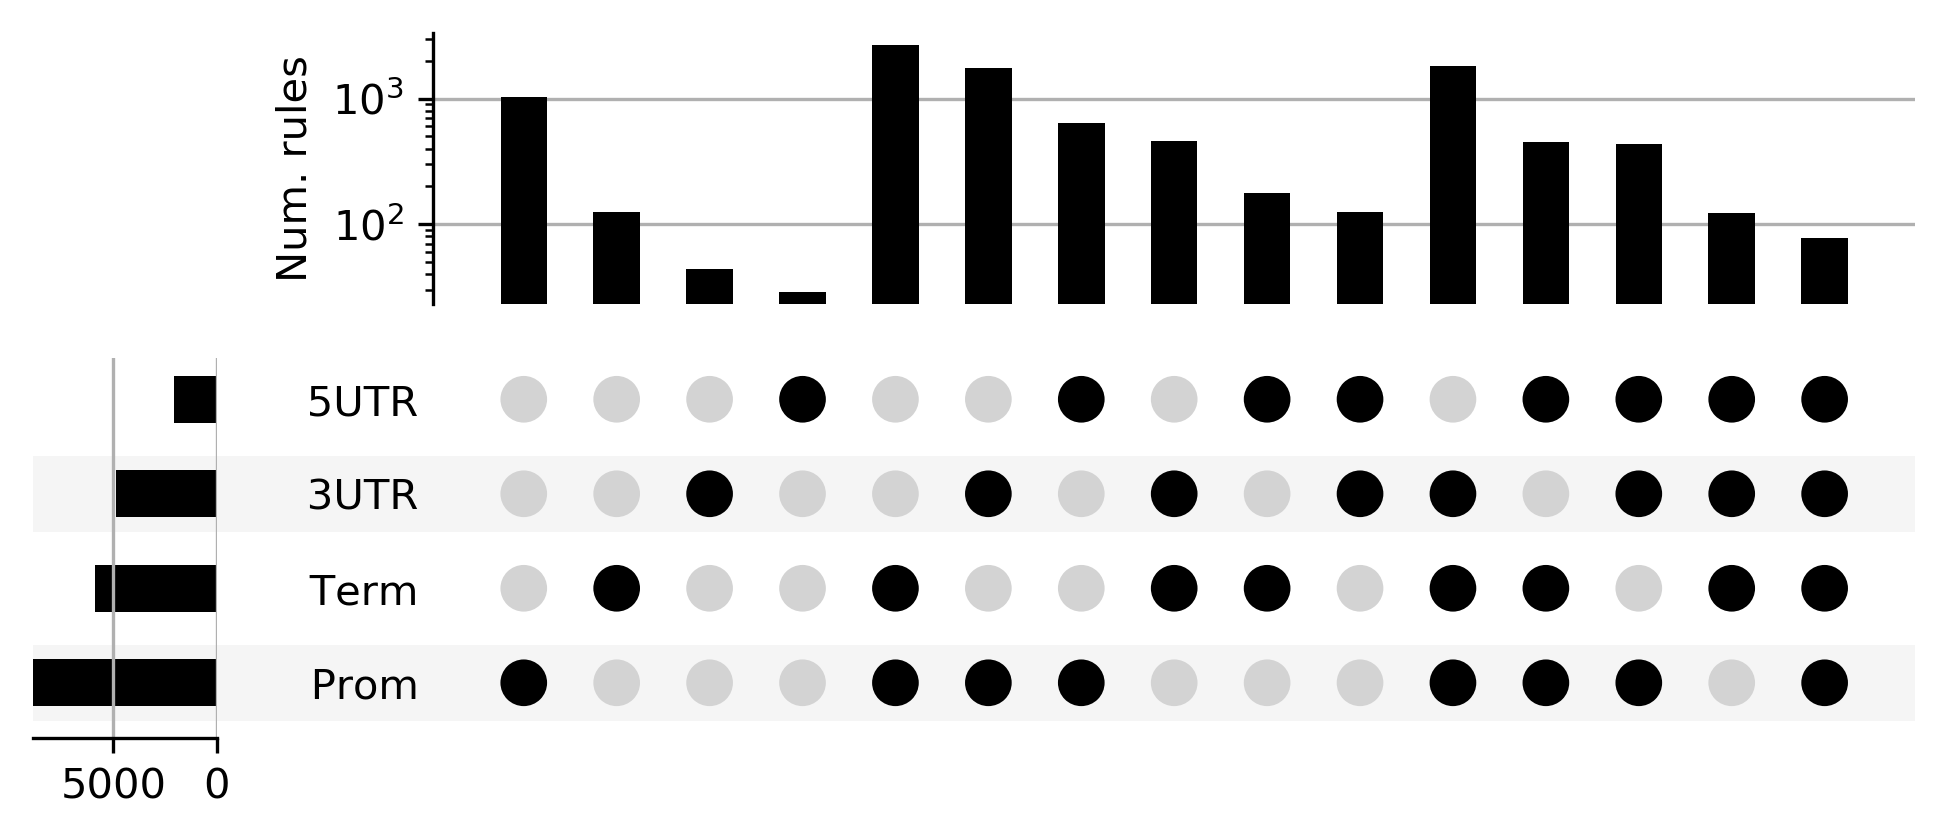

In [10]:
# Upset plot

def draw_upset_plot(df_rules):
    dataupset1 = df_rules.groupby('items_regions')['itemset'].count()
    dataupset2 = df_rules.groupby('items_regions')['num_genes'].apply(np.median)
    dataupset = pd.concat([dataupset1,dataupset2],axis=1).reset_index()
    dataupset.reset_index(inplace=True)

    data_upset = upsetplot.from_memberships(dataupset.items_regions.values,data = dataupset[['itemset','num_genes','index']].values)
    data_upset = pd.DataFrame(data_upset)
    data_upset.columns = ['num_rules','avg_genes','ind']
    data_upset
    
    data_upset.index.rename(['   Prom','   5UTR','   3UTR','   Term'],
                            inplace=True)
    # SUM OVER
    # #upsetplot.plot(data_upset, sum_over='sum_over')
    upset = upsetplot.UpSet(data_upset, sum_over='num_rules', intersection_plot_elements=3,
                           with_lines=False)
    #upset.add_catplot(value='num_rules', kind='strip', color='blue')
    upset.plot()
    ax = plt.gca()
    ax.set_ylabel('Num. rules')
    ax.set_yscale('log')
    return data_upset, dataupset

mpl.rcParams['figure.dpi'] = 300
df_upset,dataupset = draw_upset_plot(rules_fdr)
plt.savefig('f4d.svg')

In [11]:
# how much is rules across promoter, terminator and 3’-UTR regions
# than single reigons (promoter)

# print((df_upset.reset_index().iloc[[3,4,9,15,18]].num_rules
#  .sum())/(df_upset.reset_index().iloc[[0]].num_rules
#  .sum()))

print((df_upset
       .reset_index()
       .iloc[[x for x in range(df_upset.shape[0]) if x not in [0,5,8,14]]]
       .num_rules
       .sum())/(df_upset
                .reset_index()
                .iloc[[0]]
                .num_rules
                .sum())
     )


8.563173359451518


In [12]:
# How many rules in single regions vs across regions
# per nonsignificant, significant, bonferroni

def count_single_multi_regions(df):
    df_out = df.copy(deep=True)
    df_out['single'] = (df_out['items_regions']
                        .apply(lambda x: len(x)<2)
                       )
    return df_out.groupby('single')['itemset'].count()/df_out.shape[0]

df_count = pd.concat([count_single_multi_regions(df_rules),
      count_single_multi_regions(rules_sig),
      count_single_multi_regions(rules_fdr),
      count_single_multi_regions(rules_bonf)],axis=1)
df_count.columns = ['All_rules','Significant','BH-adjusted','Bonferroni']
df_count.index = ['Across_regions','Within_regions']
df_count


,All_rules,Significant,BH-adjusted,Bonferroni
Across_regions,0.817516,0.856794,0.877635,0.904607
Within_regions,0.182484,0.143206,0.122365,0.095393


In [13]:
# load gene data for below analysis

df_rsd1 = pd.read_csv(folder+fn0)
df_rsd1 = (df_rsd1 
           .set_index('gene_id')
           .loc[gene_names]
           .reset_index()
          )
print(df_rsd1.shape)

(12819950, 4)


In [14]:
# construct table of ranges
# per subset, long

p_cutoffs = [['All',1],
             ['Significant',0.05],
             ['BH-adjusted',rules_fdr.chi_pval.max()],
             ['Bonferroni',0.05/df_rules.shape[0]]]
df_stat = []
for cut in p_cutoffs:
    tmp_rules = filter_rules(df_rules[df_rules.chi_pval<=cut[1]])
    tmp_motifs = filter_motifs(df_motifs, tmp_rules)
    tmp_genes = filter_genes(df_rsd1, tmp_rules)
    df_stat.append([cut[0],
                    cut[1],
                    pd.Series(tmp_genes.groupby('gene_id')['TPM']).shape[0],
                    tmp_motifs.shape[0],
                    tmp_rules.shape[0],
                    tmp_genes.groupby('gene_id')['TPM'].apply(np.median).values,
                    tmp_motifs.ytest
                    .apply(lambda x: np.median([boxtpm(float(xx),lmbda) for xx in x]))
                    .values,
                    tmp_rules.items_ytest
                    .apply(lambda x: np.median([boxtpm(float(xx),lmbda) for xx in x]))
                    .values,
                    tmp_genes.groupby('gene_id')['TPM'].apply(np.var).values,
                    tmp_motifs.ytest
                    .apply(lambda x: np.var([boxtpm(float(xx),lmbda) for xx in x]))
                    .values,
                    tmp_rules.items_ytest
                    .apply(lambda x: np.var([boxtpm(float(xx),lmbda) for xx in x]))
                    .values,
                    tmp_genes.groupby('gene_id')['TPM'].apply(dynamic_range).values,
                    tmp_motifs.ytest
                    .apply(lambda x: dynamic_range([boxtpm(float(xx),lmbda) for xx in x]))
                    .values,
                    tmp_rules.items_ytest
                    .apply(lambda x: dynamic_range([boxtpm(float(xx),lmbda) for xx in x]))
                    .values,
                    tmp_genes.groupby('gene_id')['TPM'].apply(signal2noise).values,
                    tmp_motifs.ytest
                    .apply(lambda x: signal2noise([boxtpm(float(xx),lmbda) for xx in x]))
                    .values,
                    tmp_rules.items_ytest
                    .apply(lambda x: signal2noise([boxtpm(float(xx),lmbda) for xx in x]))
                    .values
                   ])
df_stat = pd.DataFrame(df_stat,columns=['subset','p_cutoff',
                                        'num_genes','num_motifs','num_rules',
                                        'median_genes','median_motifs','median_rules', # per element
                                        'var_genes','var_motifs','var_rules', # per element
                                        'dr_genes','dr_motifs','dr_rules', # per element
                                        'snr_genes','snr_motifs','snr_rules' # per element
                                        ])
df_stat.head()

,subset,p_cutoff,num_genes,num_motifs,num_rules,median_genes,median_motifs,median_rules,var_genes,var_motifs,var_rules,dr_genes,dr_motifs,dr_rules,snr_genes,snr_motifs,snr_rules
0,All,1.000000e+00,4235,2098,116734,"[30.417642945215412, 24.58649916653021, 1911.9...","[56.82555673056331, 59.68323116935152, 59.5358...","[46.52717432590823, 74.25348239392099, 64.7196...","[597.7384708611528, 419.00673768927504, 134596...","[96439.25024669587, 85772.95158433117, 877904....","[407.0466617385764, 4173.297332817851, 442.667...","[2.331309417553104, 2.2644343056752203, 3.9740...","[3.764929461289353, 3.671163772224524, 4.24911...","[1.693883079924885, 2.176100484752844, 1.66799...","[1.2441420063444866, 1.2011194270357712, 1.648...","[0.1829855461566501, 0.2037873161096979, 0.063...","[2.3061342147696386, 1.1494157993082754, 3.076..."
1,Significant,5.000000e-02,4192,1745,25809,"[30.417642945215412, 24.58649916653021, 1911.9...","[56.82555673056331, 59.68323116935152, 59.5358...","[90.05463558475957, 38.37679840755499, 88.9853...","[597.7384708611528, 419.00673768927504, 134596...","[96439.25024669587, 85772.95158433117, 877904....","[12264.391102961783, 4213.073152494931, 10288....","[2.331309417553104, 2.2644343056752203, 3.9740...","[3.764929461289353, 3.671163772224524, 4.24911...","[2.4077016204467006, 2.153714908543469, 2.3793...","[1.2441420063444866, 1.2011194270357712, 1.648...","[0.1829855461566501, 0.2037873161096979, 0.063...","[0.8131732382225005, 0.5912473957584423, 0.877..."
2,BH-adjusted,3.040427e-03,3926,1374,9962,"[30.417642945215412, 24.58649916653021, 1911.9...","[56.82555673056331, 59.68323116935152, 59.5358...","[65.5949871218076, 248.63717553326583, 69.7860...","[597.7384708611528, 419.00673768927504, 134596...","[96439.25024669587, 85772.95158433117, 877904....","[231.1598024765843, 25952.262427013502, 166.49...","[2.331309417553104, 2.2644343056752203, 3.9740...","[3.764929461289353, 3.671163772224524, 4.24911...","[1.5662970113352717, 2.5952922828701275, 1.490...","[1.2441420063444866, 1.2011194270357712, 1.648...","[0.1829855461566501, 0.2037873161096979, 0.063...","[4.314341254159944, 1.54339984252749, 5.408434..."
3,Bonferroni,1.621650e-07,2147,816,1541,"[30.417642945215412, 24.58649916653021, 1911.9...","[56.82555673056331, 59.68323116935152, 59.5358...","[114.69828657898564, 88.98536642382969, 40.301...","[597.7384708611528, 419.00673768927504, 134596...","[96439.25024669587, 85772.95158433117, 877904....","[3065.1250924162855, 10288.543189516493, 191.7...","[2.331309417553104, 2.2644343056752203, 3.9740...","[3.764929461289353, 3.671163772224524, 4.24911...","[2.0760535912076143, 2.3793541161798686, 1.470...","[1.2441420063444866, 1.2011194270357712, 1.648...","[0.1829855461566501, 0.2037873161096979, 0.063...","[2.071728442791413, 0.8772869126552683, 2.9106..."


In [15]:
# Count % rules above 1 snr
for xx in df_stat.subset.unique():
    print(xx)
    print(len([x for x in df_stat.set_index('subset').loc[xx,'snr_rules'] if x>=1])/
    len([x for x in df_stat.set_index('subset').loc[xx,'snr_rules']]))

#% motifs above 1 snr
for xx in df_stat.subset.unique():
    print(xx)
    print(len([x for x in df_stat.set_index('subset').loc[xx,'snr_motifs'] if x>=1])/
    len([x for x in df_stat.set_index('subset').loc[xx,'snr_motifs']]))

All
0.6010930834204259
Significant
0.6547715913053586
BH-adjusted
0.6721541859064445
Bonferroni
0.6865671641791045
All
0.21973307912297427
Significant
0.20057306590257878
BH-adjusted
0.16957787481804948
Bonferroni
0.1090686274509804


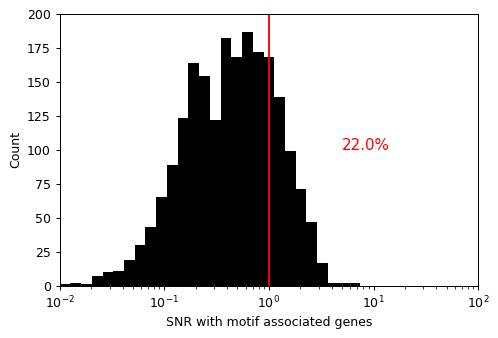

In [16]:
# plot SNR desnity for separate motifs

mpl.rcParams['figure.dpi'] = 90

perc = (len([x for x in df_stat[df_stat.subset=='All'].snr_motifs[0] if x>=1])/
    len([x for x in df_stat[df_stat.subset=='All'].snr_motifs[0]]))

bmin, bmax = 0.01, 100
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
df_stat[(df_stat.subset=='All')].snr_motifs.hist(bins = logbins,color='k')
plt.xscale('log')
plt.xlim(bmin,bmax)
plt.plot([1,1],[0,200],'r')
plt.ylim(0,200)
plt.xlabel('SNR with motif associated genes')
plt.ylabel('Count')
plt.grid(b=None)

plt.annotate('%.1f'%(perc*100)+'%',xy=(5,100),
            color='r',size=12)
plt.show()


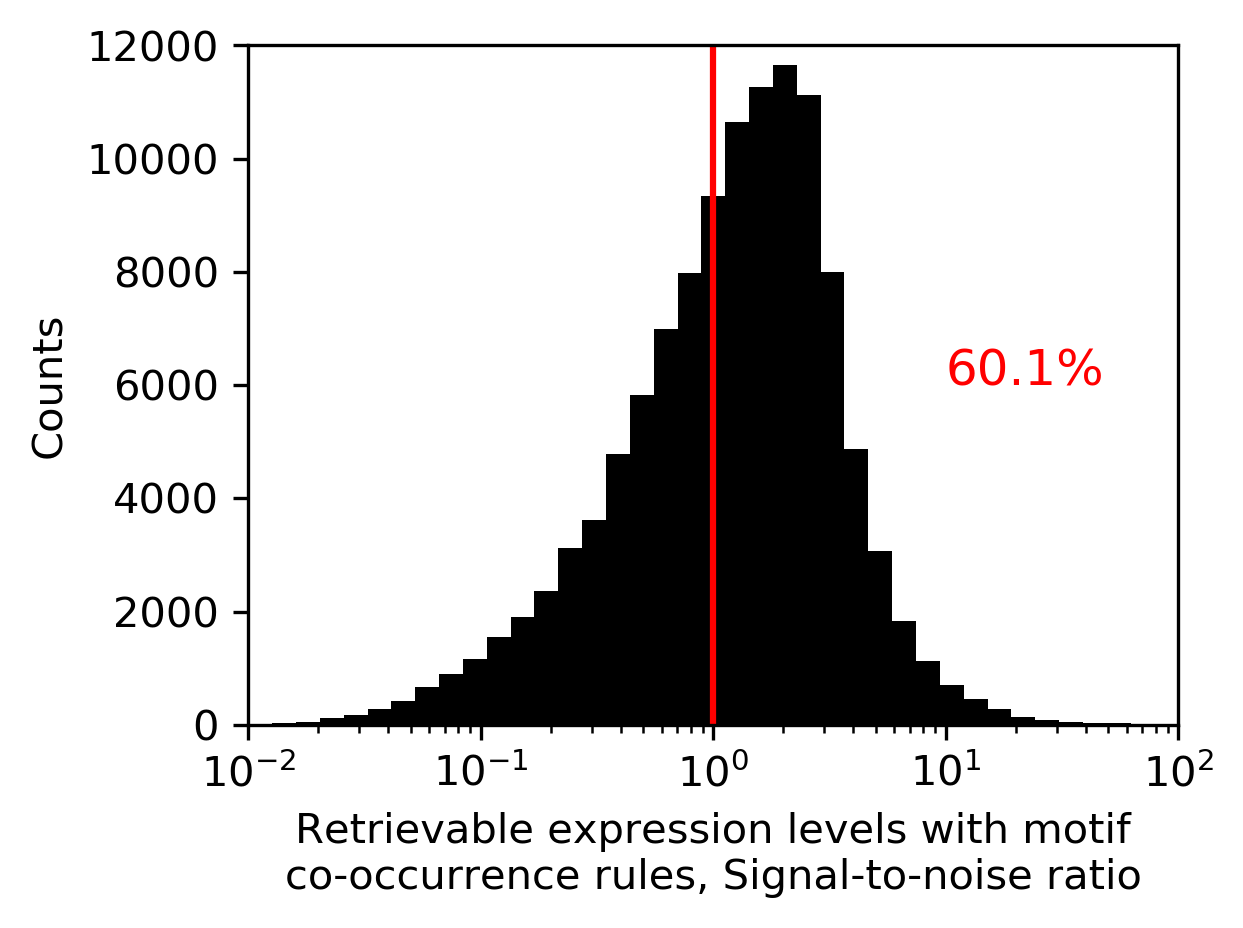

In [17]:
# plot SNR desnity for separate rules

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize = (4, 3))

perc = (len([x for x in df_stat[df_stat.subset=='All'].snr_rules[0] if x>=1])/
    len([x for x in df_stat[df_stat.subset=='All'].snr_rules[0]]))

bmin, bmax = 0.01, 100
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
df_stat[(df_stat.subset=='All')].snr_rules.hist(bins = logbins,color='k')
plt.xscale('log')
plt.xlim(bmin,bmax)
plt.plot([1,1],[0,12000],'r')
plt.ylim(0,12000)
plt.xlabel('Retrievable expression levels with motif\nco-occurrence rules, Signal-to-noise ratio')
plt.ylabel('Counts')
plt.grid(b=None)

plt.annotate('%.1f'%(perc*100)+'%',xy=(10,6000),
            color='r',size=12)

plt.savefig('f4a.svg')


In [18]:
# plot
# lonf df 
# type, value range, value var

df_tmp = (dframe_stack_list(df_stat.
            melt(id_vars=['subset'],value_vars=['median_genes','median_motifs','median_rules']),
                          'value')
            .rename(columns={'value':'median'})
         )
df_tmp['var'] = dframe_stack_list(df_stat.
            melt(id_vars=['subset'],value_vars=['var_genes','var_motifs','var_rules']),
                          'value')['value']
df_tmp['dr'] = dframe_stack_list(df_stat.
            melt(id_vars=['subset'],value_vars=['dr_genes','dr_motifs','dr_rules']),
                          'value')['value']
df_tmp['snr'] = dframe_stack_list(df_stat.
            melt(id_vars=['subset'],value_vars=['snr_genes','snr_motifs','snr_rules']),
                          'value')['value']
df_tmp['type'] = (df_tmp
                      .variable
                      .apply(lambda x: x.split('_')[1])
                     )
df_tmp = df_tmp.melt(id_vars=['subset','type'],value_vars=['median','var','dr','snr'])
df_tmp.head()

,subset,type,variable,value
0,All,genes,median,30.417643
1,All,genes,median,24.586498
2,All,genes,median,1911.958862
3,All,genes,median,212.342453
4,All,genes,median,71.685783


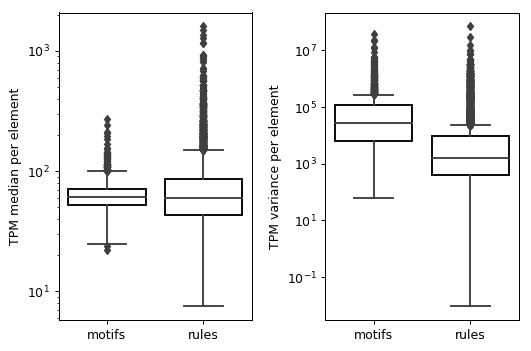

In [19]:
df_tmp = df_tmp[df_tmp.type.isin(['motifs','rules'])] 

mpl.rcParams['figure.dpi'] = 90
f2 = plt.figure(figsize=(6,4))
plt.subplot(1,2,1)
tmp = df_tmp[(df_tmp.subset=='BH-adjusted')&(df_tmp.variable=='median')]
ax = sns.boxplot(data=tmp,x='type',y='value')
plt.yscale('log')
plt.xlabel('')
plt.ylabel('TPM median per element')
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

plt.subplot(1,2,2)
tmp = df_tmp[(df_tmp.subset=='BH-adjusted')&(df_tmp.variable=='var')]
ax = sns.boxplot(data=tmp,x='type',y='value')
plt.yscale('log')
plt.xlabel('')
plt.ylabel('TPM variance per element')
plt.tight_layout()
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

plt.show()

In [20]:
# summary table 

df_ranges = (df_stat.melt(id_vars='subset',value_vars=['num_genes','num_motifs','num_rules'])
             .rename(columns={'value':'size'})
            )
df_ranges['variable'] = df_ranges.variable.apply(lambda x: x.split('_')[1])
                         
df_ranges['median_list'] = (df_stat.melt(id_vars='subset',value_vars=['median_genes','median_motifs','median_rules'])
                     .drop(columns=['subset','variable'])
                    )
df_ranges['var_list'] = (df_stat.melt(id_vars='subset',value_vars=['var_genes','var_motifs','var_rules'])
                     .drop(columns=['subset','variable'])
                   )
df_ranges['dr_list'] = (df_stat.melt(id_vars='subset',value_vars=['dr_genes','dr_motifs','dr_rules'])
                     .drop(columns=['subset','variable'])
                   )
df_ranges['snr_list'] = (df_stat.melt(id_vars='subset',value_vars=['snr_genes','snr_motifs','snr_rules'])
                     .drop(columns=['subset','variable'])
                   )

df_ranges['median_var'] = df_ranges.median_list.apply(np.var) # var(median)
df_ranges['var_median'] = df_ranges.var_list.apply(np.median) # median(var)
df_ranges['dr_median'] = df_ranges.dr_list.apply(np.median) # median(var)
df_ranges['snr_median'] = df_ranges.snr_list.apply(np.median) # median(var)
df_ranges['dr_all'] = df_ranges.median_list.apply(dynamic_range)
df_ranges['dr_ratio'] = df_ranges.dr_all.divide(df_ranges.dr_median)

df_ranges.drop(columns=['median_list','var_list','dr_list','snr_list'],inplace=True)

df_ranges 

,subset,variable,size,median_var,var_median,dr_median,snr_median,dr_all,dr_ratio
0,All,genes,4235,351333.380059,1496.982849,2.597780,1.509538,4.274398,1.645404
1,Significant,genes,4192,352935.359274,1485.261217,2.596605,1.509976,4.274398,1.646149
2,BH-adjusted,genes,3926,329307.416607,1466.876829,2.594192,1.502815,4.274398,1.647680
3,Bonferroni,genes,2147,144122.799491,1401.818638,2.587627,1.498536,3.870454,1.495754
4,All,motifs,2098,606.327688,19891.678068,2.735083,0.448132,2.443158,0.893266
5,Significant,motifs,1745,478.978987,21627.523642,2.774998,0.427358,2.395807,0.863355
6,BH-adjusted,motifs,1374,419.519120,26421.640051,2.849707,0.387854,2.395807,0.840721
7,Bonferroni,motifs,816,235.906836,38783.308052,3.060361,0.304822,2.275861,0.743658
8,All,rules,116734,4742.963694,2477.850674,2.102246,1.319037,3.592552,1.708912
9,Significant,rules,25809,5274.481679,1804.374706,2.015054,1.535155,3.346483,1.660741


In [21]:
# The spread of expression levels of motif-associated 
# genes was over X larger than its expected (median) 
# expression level (Fig S4-2), resulting in a low median 
# SNR of less than 0.4 (Fig 4A).

(df_stat[df_stat.subset=='BH-adjusted']
 .var_motifs
 .apply(lambda x: np.median(np.sqrt(x)))/
 (df_stat[df_stat.subset=='BH-adjusted']
 .median_motifs
 .apply(np.median))
)


2    2.683334
dtype: float64

In [22]:
# significance testing
# range = median values: difference of variance, Levene
# spread = variance values: differnece of distribution/means
# Mann Whitney or Wilcoxon ranksum

pval_median = between_pval(df_stat,'p_cutoff','median_motifs','median_rules','var') 
print(pval_median)
pval_var = between_pval(df_stat,'p_cutoff','var_motifs','var_rules','mean') 
print(pval_var)
pval_dr = between_pval(df_stat,'p_cutoff','dr_motifs','dr_rules','var') 
print(pval_dr)
pval_snr = between_pval(df_stat,'p_cutoff','snr_motifs','snr_rules','mean') 
print(pval_snr)

       p_cutoff          pval
0  1.000000e+00  4.250087e-30
1  5.000000e-02  1.939979e-35
2  3.040427e-03  1.078337e-34
3  1.621650e-07  2.887966e-34
       p_cutoff           pval
0  1.000000e+00  4.711753e-291
1  5.000000e-02   0.000000e+00
2  3.040427e-03  9.001580e-283
3  1.621650e-07  1.715186e-161
       p_cutoff      pval
0  1.000000e+00  0.064513
1  5.000000e-02  0.000538
2  3.040427e-03  0.004991
3  1.621650e-07  0.260812
       p_cutoff           pval
0  1.000000e+00   0.000000e+00
1  5.000000e-02   0.000000e+00
2  3.040427e-03   0.000000e+00
3  1.621650e-07  1.883277e-182


In [23]:
# ratios table 
# rules v motifs, rules v genes, motifs v genes

df_ratios = (df_ranges[df_ranges.variable=='rules'].drop(columns=['subset','variable'])
 .divide(df_ranges[df_ranges.variable=='motifs'].drop(columns=['subset','variable']).values)
 .join(df_ranges.loc[df_ranges.variable=='rules','subset'])
 .reset_index()
)
df_ratios['variable'] = 'rules_v_motifs'

tmp = (df_ranges[df_ranges.variable=='rules'].drop(columns=['subset','variable'])
 .divide(df_ranges[df_ranges.variable=='genes'].drop(columns=['subset','variable']).values)
 .join(df_ranges.loc[df_ranges.variable=='rules','subset'])
 .reset_index()
)
tmp['variable'] = 'rules_v_genes'

df_ratios = df_ratios.append(tmp,ignore_index=True)

tmp = (df_ranges[df_ranges.variable=='motifs'].drop(columns=['subset','variable'])
 .divide(df_ranges[df_ranges.variable=='genes'].drop(columns=['subset','variable']).values)
 .join(df_ranges.loc[df_ranges.variable=='motifs','subset'])
 .reset_index()
)
tmp['variable'] = 'motifs_v_genes'

df_ratios = (df_ratios
             .append(tmp,ignore_index=True)
             .set_index(['variable','subset'])
             .drop(columns=['index'])
            )
df_ratios

size  median_var  var_median  dr_median  \
variable       subset                                                      
rules_v_motifs All          55.640610    7.822443    0.124567   0.768622   
               Significant  14.790258   11.011927    0.083430   0.726146   
               BH-adjusted   7.250364   11.327258    0.061045   0.696671   
               Bonferroni    1.888480   12.766889    0.037572   0.637632   
rules_v_genes  All          27.564109    0.013500    1.655230   0.809247   
               Significant   6.156727    0.014945    1.214853   0.776034   
               BH-adjusted   2.537443    0.014430    1.099556   0.765290   
               Bonferroni    0.717746    0.020897    1.039494   0.754121   
motifs_v_genes All           0.495396    0.001726   13.287846   1.052854   
               Significant   0.416269    0.001357   14.561428   1.068702   
               BH-adjusted   0.349975    0.001274   18.012174   1.098495   
               Bonferroni    0.380065    0.001637   27.666423   1.182690   

                            snr_median    dr_all  dr_ratio  
variable       subset                                       
rules_v_motifs All            2.943409  1.470454  1.913104  
               Significant    3.592201  1.396808  1.923591  
               BH-adjusted    4.198917  1.336238  1.918033  
               Bonferroni     5.332865  1.189810  1.865982  
rules_v_genes  All            0.873801  0.840481  1.038597  
               Significant    1.016676  0.782913  1.008865  
               BH-adjusted    1.083677  0.748964  0.978667  
               Bonferroni     1.084774  0.699619  0.927727  
motifs_v_genes All            0.296867  0.571579  0.542886  
               Significant    0.283023  0.560502  0.524469  
               BH-adjusted    0.258085  0.560502  0.510245  
               Bonferroni     0.203413  0.588009  0.497179

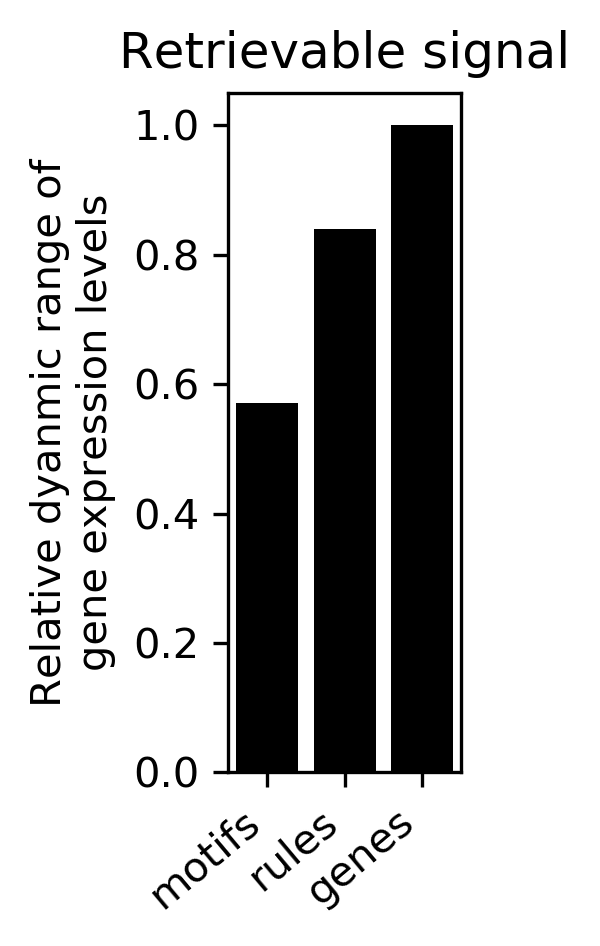

In [39]:
# plot motifs vs rules
    
df_tmp = df_tmp[df_tmp.type.isin(['motifs','rules'])] 

mpl.rcParams['figure.dpi'] = 300
f2 = plt.figure(figsize=(1,3))

#sns.set_style('white')
#plt.subplot(1,3,1)
tmp = df_ratios.loc[[('rules_v_genes','All'),('motifs_v_genes','All')]].reset_index()
tmp['variable'] = tmp.variable.apply(lambda x: x.split('_')[0])
tmp = tmp.append(pd.DataFrame(['genes','All',1,1,1,1,1,1,1],index=tmp.columns).transpose())

sns.barplot(data=tmp,
           x='variable',y='dr_all',
           order=['motifs','rules','genes'],
           linewidth=0, facecolor='black',
           errcolor=".2", edgecolor=".2")
plt.ylabel('Relative dyanmic range of\ngene expression levels')
plt.title('Retrievable signal')
plt.xlabel('')
plt.xticks(rotation=40,ha="right")

plt.savefig('f4b.svg')


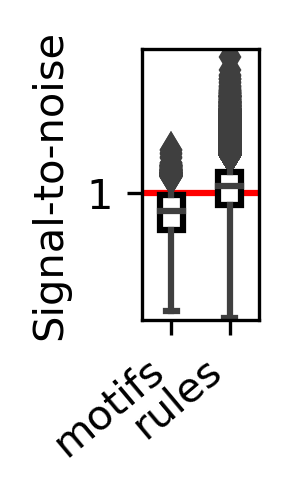

In [25]:
f2 = plt.figure(figsize=(0.5,1.2))

#plt.subplot(1,2,2)
tmp = df_tmp[(df_tmp.subset=='All')&(df_tmp.variable=='snr')]
ax = sns.boxplot(data=tmp,x='type',y='value', width=0.4)
plt.yscale('log')
plt.xlabel('')
plt.ylabel('Signal-to-noise')
plt.ylim([0.004,500])
plt.plot([-10,10],[1,1],'r',zorder=0)
#plt.title('SNR')
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
#plt.tight_layout()
plt.xticks(rotation=40,ha="right")
plt.yticks([1])
ax.set_yticklabels(['1'])

plt.savefig('f4a_ins.svg')


In [26]:
# significance gc chagnes
def pariwise_pval(dfp,col1,col2):
    pval = []
    for i in range(len(dfp[col1].unique())):
        for j in range(i+1,len(dfp[col1].unique())):
            xx = dfp[dfp[col1]==dfp[col1].unique()[i]][col2]
            yy = dfp[dfp[col1]==dfp[col1].unique()[j]][col2]
            #tmp = stats.ttest_ind(xx, yy)
            tmp = stats.ranksums(xx, yy)
            pval.append([dfp[col1].unique()[i],dfp[col1].unique()[j],tmp[1]])

    pval = pd.DataFrame(pval,columns=['model_x','model_y','pval'])
    return pval

tmp = df_tmp[(df_tmp.subset=='All')&(df_tmp.variable=='snr')]
pariwise_pval(tmp,'type','value')

,model_x,model_y,pval
0,motifs,rules,0.0


In [27]:
# the precision of expression control of genes 
# spanned by the rules was ? fold higher
# compare to the motifs

tmp.groupby('type').median().value[1]/tmp.groupby('type').median().value[0]

2.943409

# Properties of co-occurrence rules

In [28]:
# Distribution of rule size (num genes) vs rule Y_median
df_rules['itemset_size'] = df_rules.itemset.apply(len)
df_rules['ytpm_median'] = (df_rules
                           .items_ytest
            .apply(lambda x: np.median([boxtpm(float(xx),lmbda) for xx in x]))
                          )
df_rules['pval_set'] = 'All'
df_rules.loc[df_rules.chi_pval<0.05,'pval_set'] = 'Significant'
df_rules.loc[df_rules.chi_pval<=rules_fdr.chi_pval.max(),'pval_set'] = 'BH-adjusted'
df_rules.loc[df_rules.chi_pval<0.05/df_rules.shape[0],'pval_set'] = 'Bonferroni'

df_rules = filter_rules(df_rules)
print(df_rules.shape)
print(df_rules[(df_rules.pval_set.isin(['BH-adjusted','Bonferroni']))].shape)

(116734, 21)
(9962, 21)


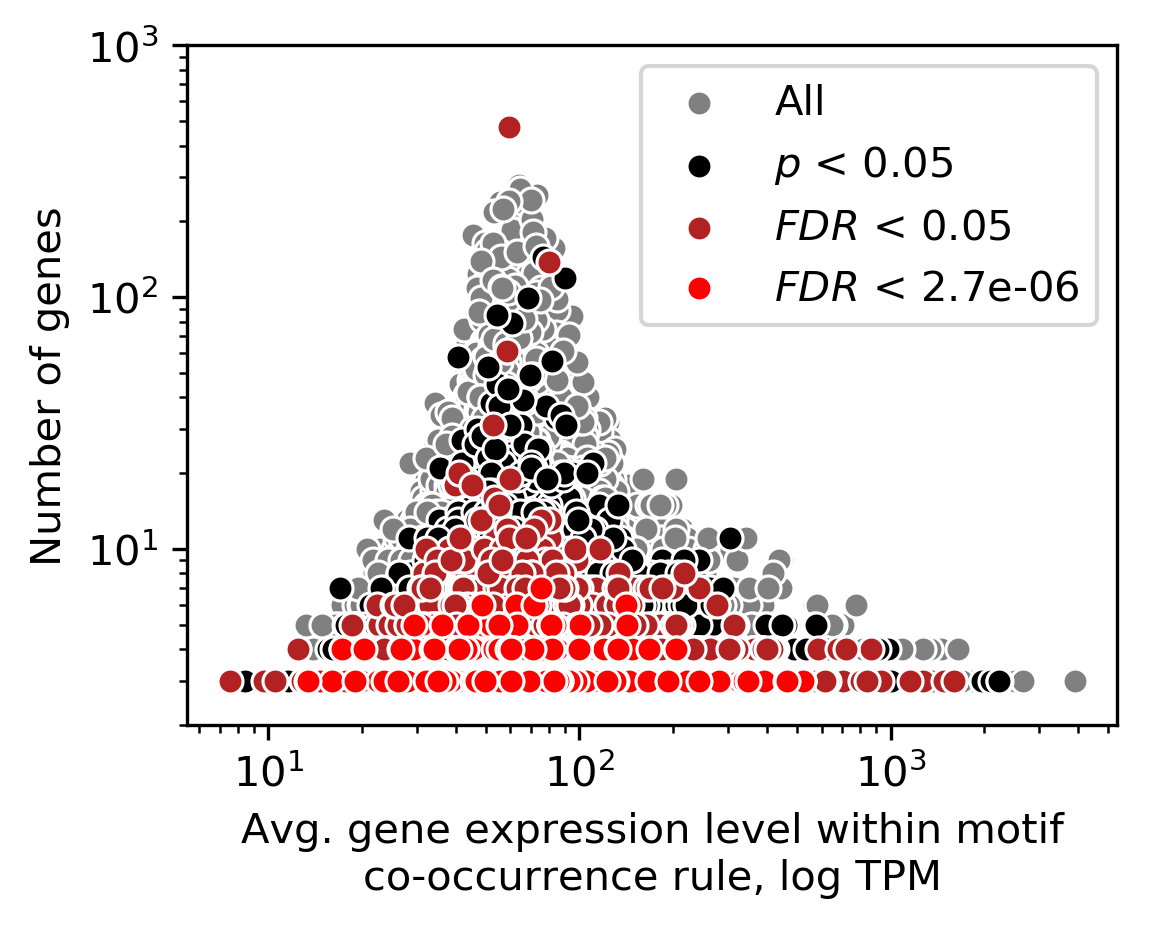

In [30]:
# plot p value as color gradient

# do significance cutoff heatmap
# Black
# 0.05 grey
# bonferonni and anything below must be its own color - red, dark red

# significance rules vs amount of genome and 
# percent motifs covered - can go to supplementary 
# or small inset here

plt.figure(figsize=(4,3))

# matplotlib
sns.scatterplot(data=df_rules[df_rules.pval_set.isin(['All','Significant','BH-adjusted','Bonferroni'])], 
                x='ytpm_median', y='num_genes',color='grey')
sns.scatterplot(data=df_rules[df_rules.pval_set.isin(['Significant','BH-adjusted','Bonferroni'])], 
                x='ytpm_median', y='num_genes',color='k')
sns.scatterplot(data=df_rules[df_rules.pval_set.isin(['BH-adjusted','Bonferroni'])], 
                x='ytpm_median', y='num_genes',color='firebrick')
sns.scatterplot(data=df_rules[df_rules.pval_set.isin(['Bonferroni'])], 
                x='ytpm_median', y='num_genes',color='r')
plt.yscale('log')
plt.xscale('log')
#plt.title('Rule distribution with increasing stat. stringency')
plt.xlabel('Avg. gene expression level within motif\nco-occurrence rule, log TPM')
plt.ylabel('Number of genes')
plt.ylim(2,1000)
p_bonf = ((0.05/3.040427e-03)*1.621650e-07)
plt.legend(['All','$p$ < 0.05','$FDR$ < 0.05','$FDR$ < %.1e'%p_bonf])

plt.savefig('f4c.svg')


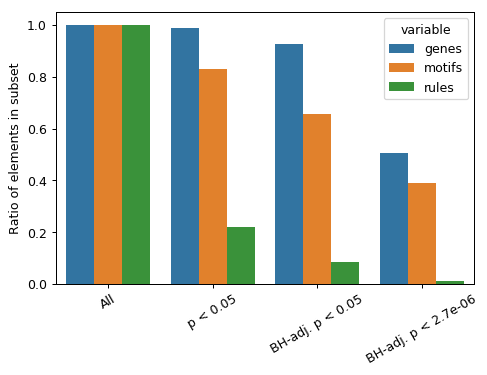

In [31]:
for var in df_ranges.variable.unique():
    df_ranges.loc[df_ranges.variable==var,'rel_size'] = (df_ranges[df_ranges.variable==var]['size'].values/
                                                         (df_ranges[(df_ranges.variable==var)&(df_ranges.subset=='All')]['size'].values))

p_subset = []
for i in range(3):
    p_subset.extend(['All','p < 0.05','BH-adj. p < 0.05','BH-adj. p < %.1e'%p_bonf])
df_ranges['p_subset'] = p_subset

mpl.rcParams['figure.dpi'] = 90
sns.barplot(data=df_ranges,
           x='p_subset',y='rel_size',
            hue='variable')
#            order=['genes','motifs'],
#            linewidth=2.5, facecolor='white',
#            errcolor=".2", edgecolor=".2")
plt.ylabel('Ratio of elements in subset')
plt.xlabel('')
plt.xticks(rotation=30)

plt.show()

In [32]:
# percent rules below 10 genes

sum(rules_fdr.num_genes<10)/rules_fdr.shape[0]

0.9962858863681991

In [33]:
# the range of expression values decreased XX-fold 
# above the threshold of 10 genes

print((df_rules[(df_rules.pval_set.isin(['BH-adjusted','Bonferroni']))&
         (df_rules.num_genes <= 10)]
 .ytpm_median
 .reset_index()
 .apply(dynamic_range)
 .ytpm_median
)/(df_rules[(df_rules.pval_set.isin(['BH-adjusted','Bonferroni']))&
         (df_rules.num_genes > 10)]
 .ytpm_median
 .reset_index()
 .apply(dynamic_range)
 .ytpm_median
))

1.987425936535594


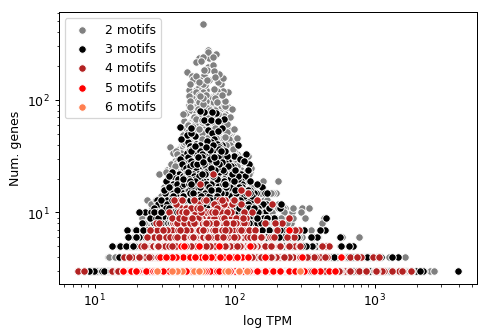

In [34]:
# Distribution of rule size (num genes) vs rule Y_median

# write size of rules
# inset barplot showing counts of rules of each size.

plt.figure(figsize=(6,4))
leg = []
colors = ['grey','k','firebrick','r','coral']
k=0
for siz in np.sort(df_rules.itemset_size.unique()):
    sns.scatterplot(data=df_rules[df_rules.itemset_size==siz], 
                    x='ytpm_median', y='num_genes',color=colors[k])
    k+=1
    #leg.append('Rules of '+str(siz)+' motifs')
    leg.append(str(siz)+' motifs')
plt.yscale('log')
plt.xscale('log')
#plt.title('Rule size (amount of co-occurring motifs)')
plt.xlabel('log TPM')
plt.ylabel('Num. genes')
plt.legend(leg,loc='upper left')
plt.show()


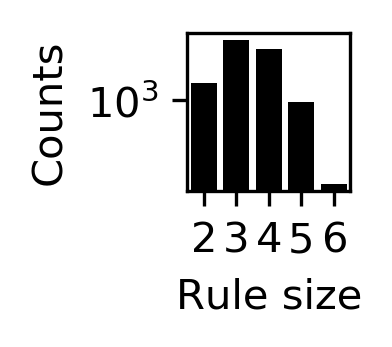

In [38]:
# Inset plot amount of rules in BH-adj subset

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(0.7,0.7))

sns.countplot(data=rules_fdr,x='itemset_size',
            linewidth=0, facecolor='black',
            edgecolor=".2")
plt.yscale('log')
#plt.title('$FDR$ < 0.05')
plt.ylabel('Counts')
plt.xlabel('Rule size')

plt.savefig('f4c_ins.svg')

# SNR specific figures

In [103]:
## dynamic range of genes, motifs, rules

def filter_motifs(df_motifs, rules_sig):
    return (df_motifs
            .iloc[np.unique(np.array([element-1 for tupl in rules_sig.itemset.values for element in tupl]))]
            .reset_index())

def filter_genes(df_genes, rules_sig):
    return (df_genes.set_index('gene_id')
            .loc[np.unique(np.array([element for tupl in rules_sig.items_gene_id.values for element in tupl]))]
            .reset_index())

# motifs
df_motifs['ytpm'] = (df_motifs
                        .ytest
                        .apply(lambda x: [boxtpm(float(xx),lmbda) for xx in x])
                         .values
                        )
df_motifs['ytpm_median'] = (df_motifs
                         .ytest
                         .apply(lambda x: np.median([boxtpm(float(xx),lmbda) for xx in x]))
                        )
df_motifs['ytpm_std'] = (df_motifs
                         .ytest
                         .apply(lambda x: np.std([boxtpm(float(xx),lmbda) for xx in x]))
                        )

# rules
df_rules['ytpm_median'] = (df_rules
                         .items_ytest
                         .apply(lambda x: np.median([boxtpm(float(xx),lmbda) for xx in x]))
                        )
df_rules['ytpm_std'] = (df_rules
                         .items_ytest
                         .apply(lambda x: np.std([boxtpm(float(xx),lmbda) for xx in x]))
                        )

tmp_rules = df_rules[(df_rules.pval_set.isin(['BH-adjusted','Bonferroni']))]
tmp_rules = dframe_stack_list(tmp_rules,'ytpm').reset_index()
print(tmp_rules.shape)

tmp_motifs = filter_motifs(df_motifs, tmp_rules)
tmp_motifs = dframe_stack_list(tmp_motifs.reset_index(drop=True),'ytpm').reset_index()
print(tmp_motifs.shape)


(34037, 24)
(67277, 25)


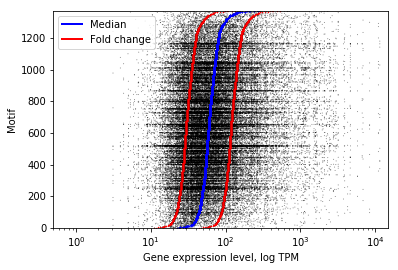

In [121]:
# plot motifs, rules

#plt.figure(figsize=(10,4))

df = tmp_motifs
ren_sort = df.sort_values(by='ytpm_median')['index'].unique()
ren_dict = dict(zip(ren_sort, range(len(ren_sort))))
df['new_index'] = df['index'].map(ren_dict)

(df#.sample(frac=0.01,random_state=77)
 .plot.scatter(x='ytpm',y='new_index',
            c='k',s=1, 
            edgecolor='',alpha=0.5
            ))
plt.scatter(df.ytpm_median,df.new_index,color='b',s=0.1)
plt.scatter(df.ytpm_median*2,df.new_index,color='r',s=0.01)
plt.scatter(df.ytpm_median/2,df.new_index,color='r',s=0.01)
# plt.scatter(df.ytpm_median+df.ytpm_std.median(),df.new_index,color='r',s=0.01)
# plt.scatter(df.ytpm_median-df.ytpm_std.median(),df.new_index,color='r',s=0.01)

mpl.rcParams['figure.dpi'] = 90

plt.xscale('log')
plt.xlim(1-1/2,10000+10000/2)
plt.ylim(-df.new_index.max()*0.001,df.new_index.max()+df.new_index.max()*0.001)
plt.xlabel('Gene expression level, log TPM')
plt.ylabel('Motif')

custom_lines = [Line2D([0], [0], color='b', lw=2),
              Line2D([0], [0], color='r', lw=2)]
plt.legend(custom_lines,['Median','Fold change'],loc=2)

plt.show()


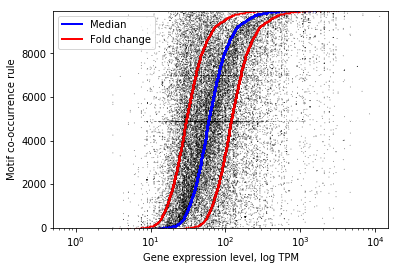

In [125]:
df = tmp_rules
ren_sort = df.sort_values(by='ytpm_median')['index'].unique()
ren_dict = dict(zip(ren_sort, range(len(ren_sort))))
df['new_index'] = df['index'].map(ren_dict)

(df#.sample(frac=0.01,random_state=77)
 .plot.scatter(x='ytpm',y='new_index',
            c='k',s=1, 
            edgecolor='',alpha=0.5
            ))
plt.scatter(df.ytpm_median,df.new_index,color='b',s=0.1)
plt.scatter(df.ytpm_median*2,df.new_index,color='r',s=0.01)
plt.scatter(df.ytpm_median/2,df.new_index,color='r',s=0.01)
#plt.scatter(df.ytpm_median+df.ytpm_std,df.new_index,color='r',s=0.01)
#plt.scatter(df.ytpm_median-df.ytpm_std,df.new_index,color='r',s=0.01)

plt.xscale('log')
plt.xlim(1-1/2,10000+10000/2)
plt.ylim(-df.new_index.max()*0.001,df.new_index.max()+df.new_index.max()*0.001)
plt.xlabel('Gene expression level, log TPM')
plt.ylabel('Motif co-occurrence rule')

custom_lines = [Line2D([0], [0], color='b', lw=2),
              Line2D([0], [0], color='r', lw=2)]
plt.legend(custom_lines,['Median','Fold change'],loc=2)

plt.show()


# Rules rewire motifs

In [36]:
## load data
# reformat list and set variables
# keep itemsets

def fix_frame(rules2):
    rules2['itemset'] = rules2.itemset.apply(fix_int_tuple)
    rules2['items_cluster'] = rules2.items_cluster.apply(fix_strings_tuple)
    rules2['items_regions'] = rules2.items_regions.apply(fix_strings_tuple)
    rules2['items_genes'] = rules2.items_genes.apply(fix_strings_tuple)
    rules2['items_gene_id'] = rules2.items_gene_id.apply(fix_strings_list)
    rules2['items_ytest'] = rules2.items_ytest.apply(fix_float_list_comma)
    rules2['ytpm'] = rules2.ytpm.apply(fix_float_list_space)
    rules2['antecedent'] = rules2.antecedent.apply(fix_int_list_comma)
    rules2['consequent'] = rules2.consequent.apply(fix_int_list_comma)
    #rules2['ytpm'] = rules2.ytpm.apply(fix_float_list_space)
    return rules2

df_rules = pd.read_csv(folder+fn12)
df_rules = fix_frame(df_rules)

# drop precalculated values except y boxcox
df_rules.drop(columns=['y_mean','y_std','y_var','ytpm_mean','ytpm_std','ytpm_var','ytpm_median'],# !!ytpm_median was mean
             inplace=True)

print(df_rules.shape)

rules_sig, rules_fdr, rules_bonf = return_significant_rules(df_rules, p_cut=0.05)

# fix dataset entries
rules_fdr['ytpm_median'] = (rules_fdr
                           .items_ytest
                            .apply(lambda x: np.median([boxtpm(float(xx),lmbda) for xx in x]))
                           )
rules_fdr['antecedent'] = rules_fdr.antecedent.apply(lambda x: tuple(x)) 
rules_fdr['consequent'] = rules_fdr.consequent.apply(lambda x: tuple(x))

rules_fdr.head()

(308328, 18)


,antecedent,consequent,confidence,lift,itemset,support,chi_square,chi_pval,items_cluster,items_regions,items_genes_all,items_genes,num_genes,items_ytest,median_ytest,items_gene_id,itemset_size,ytpm,ytpm_median
84296,"(189, 1915, 166)","(934,)",0.600000,121.085714,"(189, 1915, 166, 934)",0.000708,187.461632,0.0,"(0_22, 3_4, 0_2, 1_19)","(3_terminator, 1_5UTR, 0_promoter)","[frozenset({3584, 1539, 516, 3078, 3593, 4106,...","(frozenset{2736, 2405, 2495})",3,"[4.3786836, 6.0342317, 7.060977499999999]",6.034232,"[YJL025W, YDR089W, YOR127W]",4,"[21.4668353, 46.52717433, 70.88459804]",46.527174
196973,"(1810, 788, 1387)","(186,)",0.750000,72.238636,"(1810, 788, 1387, 186)",0.000708,111.162129,0.0,"(3_29, 0_9, 2_3, 0_217)","(0_promoter, 2_3UTR, 3_terminator)","[frozenset({3076, 6, 2566, 1033, 3596, 1549, 1...","(frozenset{3706, 3687, 3071})",3,"[9.920467, 5.846362, 7.180144]",7.180144,"[YBL007C, YAL059W, YNR037C]",4,"[192.89131095, 42.88812447, 74.25348239]",74.253482
232826,"(1542, 131)","(1353,)",0.142857,75.678571,"(1542, 131, 1353)",0.000708,116.077913,0.0,"(2_7, 0_17, 2_251)","(2_3UTR, 0_promoter)","[frozenset({512, 3072, 3584, 3587, 4096, 2565,...","(frozenset{1880, 2539, 3549})",3,"[6.98725, 4.4539933, 6.830955]",6.830955,"[YGR009C, YGL251C, YMR004W]",3,"[68.86079482, 22.3026785, 64.71961186]",64.719612
19852,"(2179, 689)","(1889,)",1.000000,48.159091,"(2179, 689, 1889)",0.000708,73.828754,0.0,"(3_87, 0_73, 3_37)","(0_promoter, 3_terminator)","[frozenset({1792, 899, 2821, 1672, 2953, 394, ...","(frozenset{1772, 2821, 3119})",3,"[3.9980206, 8.2436905, 8.103644000000001]",8.103644,"[YDR126W, YER007C-A, YDL099W]",3,"[17.60819068, 110.18182747, 104.80304351]",104.803044
40086,"(4, 1606)","(726,)",0.600000,51.893878,"(4, 1606, 726)",0.000708,79.091682,0.0,"(0_100, 3_11, 0_79)","(3_terminator, 0_promoter)","[frozenset({1537, 11, 2575, 2065, 3089, 3606, ...","(frozenset{3201, 979, 878})",3,"[5.125091599999999, 5.864013, 4.068951]",5.125092,"[YDL089W, YOL113W, YDL129W]",3,"[30.92679533, 43.22024814, 18.2825318]",30.926795


(16855, 19)
(13710, 2)
(3319, 2)
0.24208606856309264
604.8093701506134
(16855, 19)
(1079, 2)
(594, 2)
0.5505097312326228
1483.801817541569


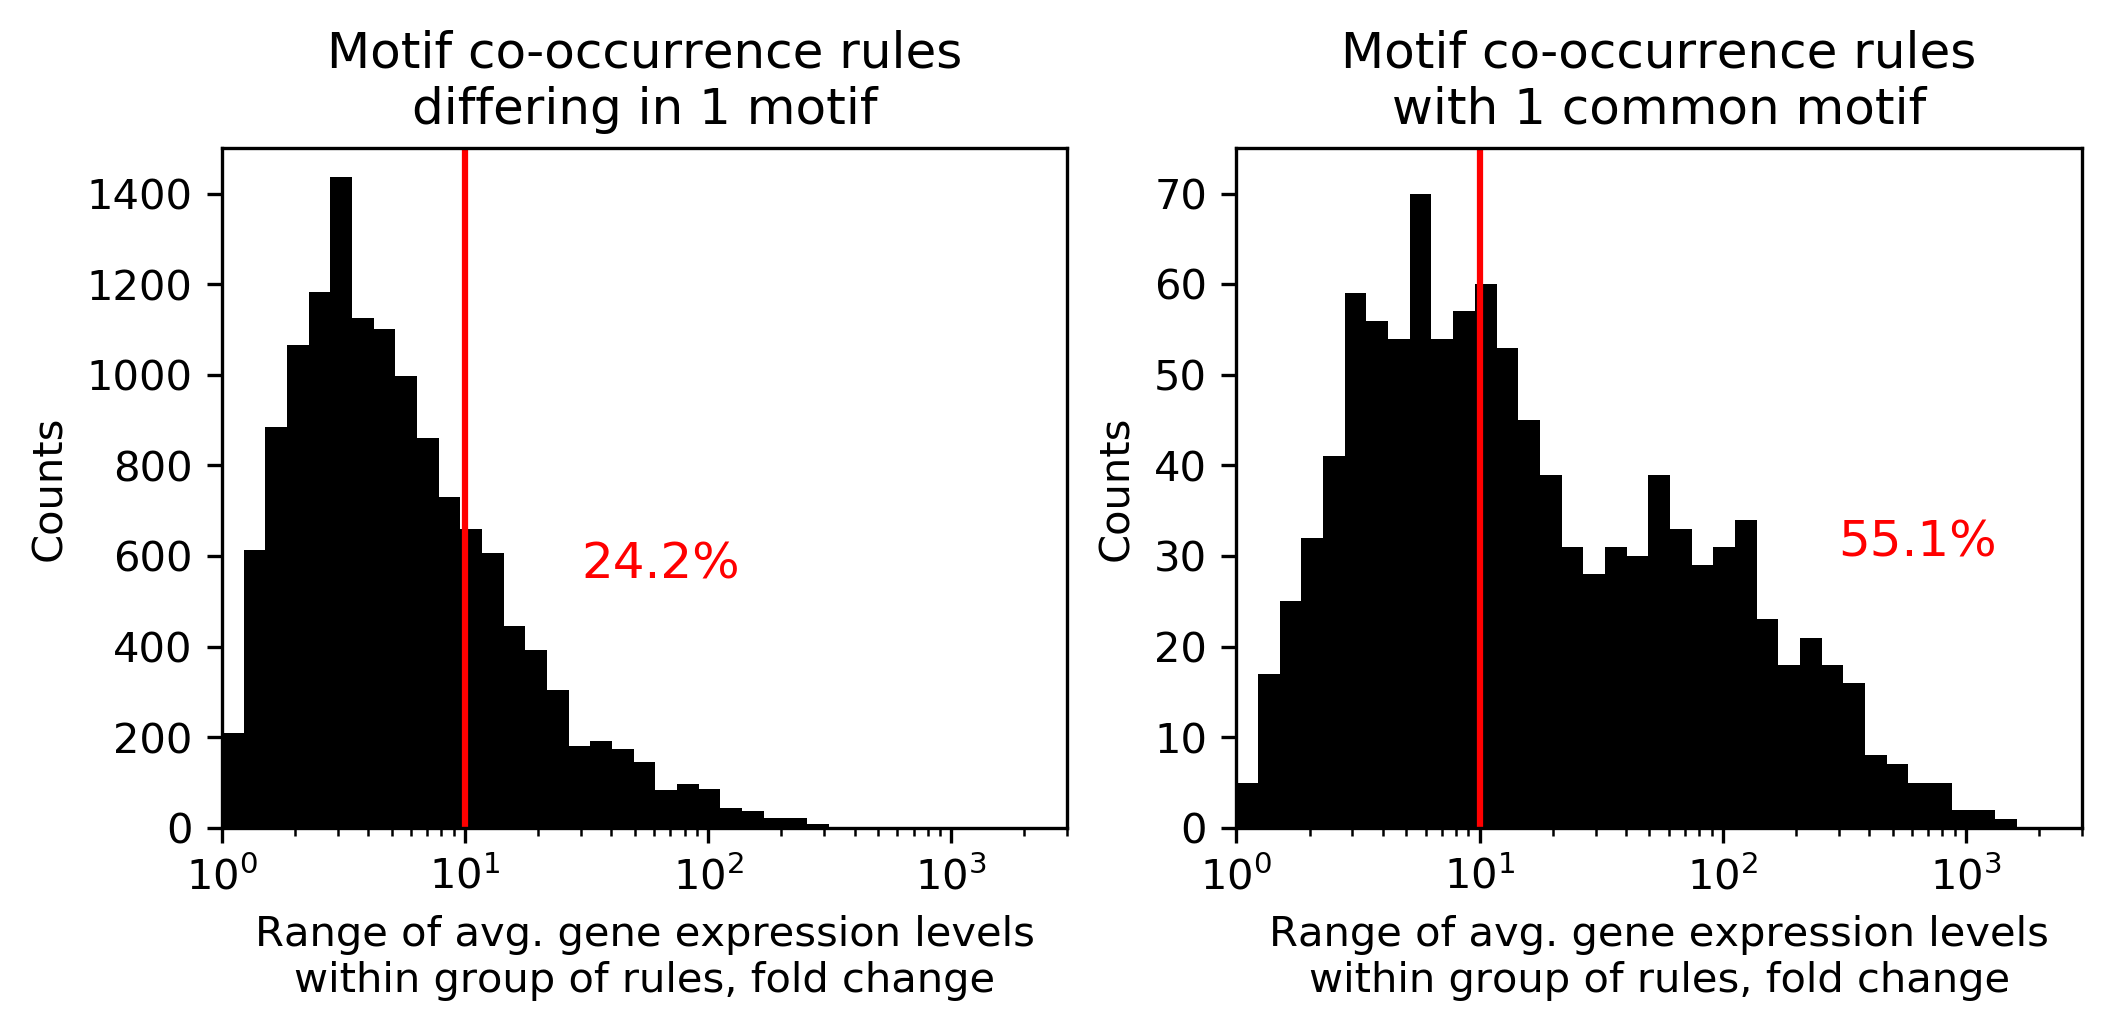

In [37]:
# ratio of median gene expression levels in rules differing in motifs
# fdr
# groupby antecedent itemset size > 1

# take into account ytpm min and max not ytpm_median

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)

bmin, bmax = 1, 3000
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)

print(rules_fdr[rules_fdr.antecedent.apply(len) > 1].shape)

(rules_fdr[rules_fdr.antecedent.apply(len) > 1]
 .groupby('antecedent')
# .ytpm_median
 .ytpm.apply(lambda x: [el for it in x for el in it]) #flatten
 .apply(lambda x: max(x)/min(x))
 .where(lambda x: x>1)
 .dropna()
 .hist(bins = logbins,color='k')
)
#plt.yscale('log')
plt.xscale('log')
plt.xlim(bmin,bmax)
plt.title('Motif co-occurrence rules\ndiffering in 1 motif')
plt.xlabel('Range of avg. gene expression levels\nwithin group of rules, fold change')
plt.ylabel('Counts')
plt.grid(b=None)

# count number rulesets above fold change 10
df_ratio = pd.DataFrame(rules_fdr[rules_fdr.antecedent.apply(len) > 1]
 .groupby('antecedent')
# .ytpm_median
 .ytpm.apply(lambda x: [el for it in x for el in it]) #flatten
 .apply(lambda x: max(x)/min(x))
 .dropna()
).reset_index()
plt.annotate('%.1f'%(100*df_ratio[df_ratio.ytpm>=10].shape[0]/df_ratio.shape[0])+'%',
             xy=(30,550),color='r',size=12)

plt.plot([10,10],[0,1500],'r')
plt.ylim(0,1500)

print(df_ratio.shape)
print(df_ratio[df_ratio.ytpm>=10].shape)
print(df_ratio[df_ratio.ytpm>=10].shape[0]/df_ratio.shape[0])
print(df_ratio.ytpm.max())

# maybe also other way around, we should group 
# by consequents and see how antecedents affect

# ratio of median gene expression levels in rules differing in motifs
# fdr
# groupby antecedent itemset size > 1

plt.subplot(1,2,2)

bmin, bmax = 1, 3000
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)

print(rules_fdr[rules_fdr.antecedent.apply(len) > 1].shape)

(rules_fdr[rules_fdr.antecedent.apply(len) > 1]
 .groupby('consequent')
# .ytpm_median
 .ytpm.apply(lambda x: [el for it in x for el in it]) #flatten
 .apply(lambda x: max(x)/min(x))
 .where(lambda x: x>1)
 .dropna()
 .hist(bins = logbins,color='k')
)
#plt.yscale('log')
plt.xscale('log')
plt.xlim(bmin,bmax)
plt.title('Motif co-occurrence rules\nwith 1 common motif')
plt.xlabel('Range of avg. gene expression levels\nwithin group of rules, fold change')
plt.ylabel('Counts')
plt.grid(b=None)

# count number rulesets above fold change 10
df_ratio = pd.DataFrame(rules_fdr[rules_fdr.antecedent.apply(len) > 1]
 .groupby('consequent')
# .ytpm_median
 .ytpm.apply(lambda x: [el for it in x for el in it]) #flatten
 .apply(lambda x: max(x)/min(x))
 .dropna()
).reset_index()
plt.annotate('%.1f'%(100*df_ratio[df_ratio.ytpm>=10].shape[0]/df_ratio.shape[0])+'%',
             xy=(300,30),color='r',size=12)

plt.plot([10,10],[0,75],'r')
plt.ylim(0,75)

print(df_ratio.shape)
print(df_ratio[df_ratio.ytpm>=10].shape)
print(df_ratio[df_ratio.ytpm>=10].shape[0]/df_ratio.shape[0])
print(df_ratio.ytpm.max())

plt.savefig('f4e.svg')


In [88]:
# count number rulesets above fold change 10
cut_val = 10

df_ratio = pd.DataFrame(rules_fdr[rules_fdr.antecedent.apply(len) > 1]
 .groupby('consequent')
# .ytpm_median
 .ytpm.apply(lambda x: [el for it in x for el in it]) #flatten
 .apply(lambda x: max(x)/min(x))
 .dropna()
).reset_index()

# list of tuples
df_ratio['antecedent'] = (rules_fdr[rules_fdr.antecedent.apply(len) > 1]
                         .groupby('consequent')
                         .antecedent
                         .apply(lambda x: [xx for xx in x])
                         .values
                         )

df_ratio['rule_ids'] = (rules_fdr[rules_fdr.antecedent.apply(len) > 1]
                         .reset_index()
                         .groupby('consequent')
                         .index
                         .apply(lambda x: [xx for xx in x])
                         .values
                         )

print(df_ratio[df_ratio.ytpm>=cut_val].shape)
df_ratio.sort_values(by='ytpm',ascending=False).head()

(594, 4)


,consequent,ytpm,antecedent,rule_ids
711,"(1452,)",1483.801818,"[(378, 1995), (9, 11), (1231, 74, 2), (568, 12...","[228638, 233457, 167588, 73020, 237046, 167784..."
77,"(131,)",1253.559330,"[(1393, 1252), (988, 275), (445, 486, 2), (108...","[136965, 265551, 230940, 280552, 69829, 172504..."
147,"(211,)",1253.559330,"[(988, 1588), (616, 397, 1819, 1), (1758, 1318...","[27155, 280485, 1593, 53503, 212513, 204286, 1..."
738,"(1522,)",917.001645,"[(21, 243, 1586), (839, 2), (21, 243), (232, 2...","[54559, 153639, 52133, 32698, 133409, 285351, ..."
661,"(1318,)",880.044425,"[(980, 1522), (608, 51, 1), (122, 1218), (1769...","[145498, 50964, 118632, 229321, 298017, 290904..."


In [127]:
# get motifs ids that hit to jaspar motifs

folder2 = 'tomtom_jaspar-fungi_08_trimmed/'
           #'tomtom_yeastract_08_trimmed/']
tomtom2 = pd.read_csv(folder+folder2+'tomtom.txt',sep='\t')
tomtom2.drop(index=tomtom2.index.values[-3:],inplace=True)#.drop(index=[10092,10093,10094])
tomtom2.tail()
# filter at least 0.01 evalue
df_dbs = tomtom2[(tomtom2['E-value']<0.05) & (tomtom2['q-value']<0.05)]

df_jaspar = pd.read_csv(folder+fn14,
                        names=['id','jaspar_id','id2','source','gene_name','gene_id','gene_id_type','protein_id'],
                        skiprows=1).drop(columns=['id','id2','source','gene_id','gene_id_type','protein_id'])
df_jaspar.head()

#df_dbs['target_name'] = df_jaspar.set_index('jaspar_id').loc(df_dbs['Target ID'].values).gene_name
df_dbs = df_dbs.merge(df_jaspar,left_on='Target ID',right_on='jaspar_id',how='left')
df_dbs.head()

,#Query ID,Target ID,Optimal offset,p-value,E-value,q-value,Overlap,Query consensus,Target consensus,Orientation,jaspar_id,gene_name
0,0_0,MA0398.1,-2,0.000026,0.004617,0.009175,9,AAAAAAATTAT,AAAAATTTT,-,MA0398.1,SUM1
1,0_1,MA0277.1,0,0.000133,0.023438,0.046273,9,AAAAATAAA,AAAAAGAAA,+,MA0277.1,AZF1
2,0_100,MA0287.1,0,0.000003,0.000494,0.000976,10,CAGCAGAGAA,CAGCAAAAATG,+,MA0287.1,CUP2
3,0_1037,MA0368.1,0,0.000040,0.006971,0.013933,7,CTTGGCAACACGTATATCAATA,CTTGGCG,-,MA0368.1,RIM101
4,0_1052,MA0386.1,1,0.000069,0.012147,0.024140,16,TTATATATATGGTCCT,ATCGAATATATATATCTAGTC,-,MA0386.1,SPT15


In [128]:
# merge hit queries to consequents to get gene names per rule

df_hits = (df_dbs
            .groupby('gene_name')['#Query ID']
           .apply(list)
           .reset_index()
           .rename(columns={'#Query ID':'query_id'})
          )
#df_hits
#dframe_stack_list(df_hits,'query_id','str')

# get cluster id from df_motifs
df_ratio2 = dframe_stack_list(df_ratio,'consequent','int')
df_ratio2['cluster_id'] = (df_motifs
                           .loc[[x+1 for x in df_ratio2.consequent.values]]
                           .cluster
                           .values
                          )
# get gene_name from df_hits
df_ratio2 = (df_ratio2
             .merge(dframe_stack_list(df_hits,'query_id','str'),
               left_on='cluster_id',right_on='query_id')
             .dropna()
            )
df_ratio2['num_rules'] = (df_ratio2
                          .antecedent
                          .apply(len)
                         .values
                         )
df_ratio2['motif_region'] = (df_ratio2
                       .cluster_id
                       .apply(lambda x: names_plot[int(x.split('_')[0])])
                      )
print(df_ratio2.shape)
df_ratio2.head()


(164, 9)


,ytpm,antecedent,rule_ids,consequent,cluster_id,gene_name,query_id,num_rules,motif_region
0,55.297752,"[(309, 1452, 1), (1090, 1231), (1936, 275, 1)]","[84474, 21653, 95644]",2,0_100,CUP2,0_100,3,Promoter
1,30.017150,"[(587, 166, 1387), (1319, 1660), (843, 1), (38...","[155349, 254699, 94410, 200425, 242606, 35545,...",49,0_12,AZF1,0_12,21,Promoter
2,2.718139,"[(221, 1492), (221, 1318)]","[194848, 80928]",77,0_1320,REB1,0_1320,2,Promoter
3,166.030762,"[(352, 2161, 788), (352, 1623, 788), (1973, 18...","[18915, 246724, 297949, 108865, 265610, 221848...",85,0_137,SFP1,0_137,46,Promoter
4,166.030762,"[(352, 2161, 788), (352, 1623, 788), (1973, 18...","[18915, 246724, 297949, 108865, 265610, 221848...",85,0_137,STB3,0_137,46,Promoter


In [129]:
# split back to separate antecedent sets
# get cluster id from df_motifs
# get regions

# optimize stack function
def dframe_stack_list(ins,col):
    df = ins.copy(deep=True)
    s = df[col].apply(lambda x: pd.Series(x),1).stack()#.astype(typ)
    s.index = s.index.droplevel(-1)
    s.name = col
    del df[col]
    df = df.join(s)
    return df

df_ratio2['antecedent_set'] = df_ratio2.antecedent.values
df_ratio3 = dframe_stack_list(df_ratio2,'antecedent')

df_ratio3['ant_cluster'] = (df_ratio3
 .antecedent
 .apply(lambda x: tuple([df_motifs.loc[xx+1,'cluster'] for xx in x]))
)

df_ratio3['ant_region'] = (df_ratio3
 .antecedent
 .apply(lambda x: tuple([df_motifs.loc[xx+1,'cluster'] for xx in x]))
 .apply(lambda x: tuple(np.unique([names_plot[int(xx.split('_')[0])] for xx in x])))
)

df_ratio3['num_region'] = (df_ratio3
 .ant_region
 .apply(len)
)

df_ratio3[(df_ratio3.ytpm>=cut_val)&(df_ratio3.num_region>2)].head()

,ytpm,rule_ids,consequent,cluster_id,gene_name,query_id,num_rules,motif_region,antecedent_set,antecedent,ant_cluster,ant_region,num_region
11,16.406314,"[76689, 43510, 201805, 224008, 303282, 176228,...",102,0_150,SFP1,0_150,26,Promoter,"[(1800, 1318, 1), (758, 770, 1), (758, 770), (...","(1800, 1318, 1)","(3_281, 2_201, 0_10)","(3UTR, Promoter, Terminator)",3
11,16.406314,"[76689, 43510, 201805, 224008, 303282, 176228,...",102,0_150,SFP1,0_150,26,Promoter,"[(1800, 1318, 1), (758, 770, 1), (758, 770), (...","(2161, 155, 1218)","(3_801, 0_191, 2_10)","(3UTR, Promoter, Terminator)",3
11,16.406314,"[76689, 43510, 201805, 224008, 303282, 176228,...",102,0_150,SFP1,0_150,26,Promoter,"[(1800, 1318, 1), (758, 770, 1), (758, 770), (...","(1750, 1218, 1)","(3_231, 2_10, 0_10)","(3UTR, Promoter, Terminator)",3
11,16.406314,"[76689, 43510, 201805, 224008, 303282, 176228,...",102,0_150,SFP1,0_150,26,Promoter,"[(1800, 1318, 1), (758, 770, 1), (758, 770), (...","(1606, 1318, 1)","(3_111, 2_201, 0_10)","(3UTR, Promoter, Terminator)",3
11,16.406314,"[76689, 43510, 201805, 224008, 303282, 176228,...",102,0_150,SFP1,0_150,26,Promoter,"[(1800, 1318, 1), (758, 770, 1), (758, 770), (...","(2161, 1218, 1)","(3_801, 2_10, 0_10)","(3UTR, Promoter, Terminator)",3


In [130]:
# construct frame
# take motifs in promoters, with change above 10 fold

# gene names and cluster ids both motif and antecedents
# regions and regions num max - important to fish out ones across all
# ratio change
# num_rules altogether - show some huge families

df = (df_ratio3[(df_ratio3.ytpm>=cut_val) 
               &(df_ratio3.motif_region=='Promoter')]
      .reset_index())

df_tmp = (df
          .groupby(['index','gene_name'])
          .ant_region
          .apply(tuple)
          .reset_index()
         )
df_tmp['cluster_id'] = (df
          .groupby(['index','gene_name'])
          .query_id
          .apply(lambda x: np.unique(x)[0])
          .values
         )
df_tmp['ant_cluster'] = (df
          .groupby(['index','gene_name'])
          .ant_cluster
          .apply(tuple)
          .values
         )
df_tmp['ratio'] = (df
          .groupby(['index','gene_name'])
          .ytpm
          .unique()
          .apply(lambda x: x[0])
          .values
         )
df_tmp['num_rules'] = (df
          .groupby(['index','gene_name'])
          .num_rules
          .apply(lambda x: np.unique(x)[0])
          .values
         )
df_tmp['max_regions'] = (df_tmp
            .ant_region
            .apply(lambda x: len([x for x in np.unique([el for it in x for el in it]) if x not in 'Promoter']))
            .values
         )
df_tmp['rule_ids'] = (df
            .groupby(['index','gene_name'])
            .rule_ids
            .apply(lambda x: np.unique(x)[0])
            .values
         )

df = df_tmp[df_tmp.max_regions>2].sort_values(by='ratio',ascending=False)
df.reset_index(drop=True,inplace=True)
df

,index,gene_name,ant_region,cluster_id,ant_cluster,ratio,num_rules,max_regions,rule_ids
0,72,SPT15,"((3UTR, Promoter, Terminator), (Promoter, Term...",0_87,"((2_807, 3_500, 0_701, 0_10), (0_672, 3_500, 0...",648.016070,144,3,"[135121, 208452, 228384, 276262, 118601, 18832..."
1,71,NHP6B,"((3UTR, Promoter, Terminator), (Promoter, Term...",0_87,"((2_807, 3_500, 0_701, 0_10), (0_672, 3_500, 0...",648.016070,144,3,"[135121, 208452, 228384, 276262, 118601, 18832..."
2,70,NHP6A,"((3UTR, Promoter, Terminator), (Promoter, Term...",0_87,"((2_807, 3_500, 0_701, 0_10), (0_672, 3_500, 0...",648.016070,144,3,"[135121, 208452, 228384, 276262, 118601, 18832..."
3,69,MOT2,"((3UTR, Promoter, Terminator), (Promoter, Term...",0_87,"((2_807, 3_500, 0_701, 0_10), (0_672, 3_500, 0...",648.016070,144,3,"[135121, 208452, 228384, 276262, 118601, 18832..."
4,66,ABF1,"((3UTR, Promoter), (Promoter, Terminator), (Pr...",0_824,"((2_112, 2_201, 0_100, 0_10), (3_494, 0_371, 0...",298.672794,32,3,"[25637, 264454, 69797, 167295, 279506, 297253,..."
5,64,NHP6B,"((Promoter, Terminator), (3UTR, Promoter), (5U...",0_773,"((0_87, 0_1000, 3_300), (2_245, 0_602), (1_56,...",179.089698,23,3,"[283129, 111118, 206104, 165981, 251057, 41105..."
6,3,SFP1,"((Promoter, Terminator), (Promoter, Terminator...",0_137,"((0_371, 3_801, 0_900), (0_371, 3_1202, 0_900)...",166.030762,46,3,"[18915, 246724, 297949, 108865, 265610, 221848..."
7,4,STB3,"((Promoter, Terminator), (Promoter, Terminator...",0_137,"((0_371, 3_801, 0_900), (0_371, 3_1202, 0_900)...",166.030762,46,3,"[18915, 246724, 297949, 108865, 265610, 221848..."
8,5,SUM1,"((Promoter, Terminator), (Promoter, Terminator...",0_137,"((0_371, 3_801, 0_900), (0_371, 3_1202, 0_900)...",166.030762,46,3,"[18915, 246724, 297949, 108865, 265610, 221848..."
9,44,HAP3,"((3UTR, Terminator), (Terminator,), (3UTR, Pro...",0_361,"((3_1039, 2_71, 3_700), (3_1039, 3_700), (2_16...",132.434763,83,3,"[257837, 162159, 240441, 129047, 75278, 33784,..."


In [131]:
# get motif q-values
l = []
for cl in df.cluster_id.unique():
    #print(df_dbs[df_dbs['#Query ID']==cl][['gene_name','q-value']])
    l.append(df_dbs[df_dbs['#Query ID']==cl][['gene_name','q-value']])
    
tmp = pd.concat(l)

# copy cluster ids to merge framse
tmp['cluster_id'] = df.cluster_id.values
df = df.merge(tmp,on=['gene_name','cluster_id'])
df


,index,gene_name,ant_region,cluster_id,ant_cluster,ratio,num_rules,max_regions,rule_ids,q-value
0,72,SPT15,"((3UTR, Promoter, Terminator), (Promoter, Term...",0_87,"((2_807, 3_500, 0_701, 0_10), (0_672, 3_500, 0...",648.016070,144,3,"[135121, 208452, 228384, 276262, 118601, 18832...",0.006568
1,71,NHP6B,"((3UTR, Promoter, Terminator), (Promoter, Term...",0_87,"((2_807, 3_500, 0_701, 0_10), (0_672, 3_500, 0...",648.016070,144,3,"[135121, 208452, 228384, 276262, 118601, 18832...",0.004489
2,70,NHP6A,"((3UTR, Promoter, Terminator), (Promoter, Term...",0_87,"((2_807, 3_500, 0_701, 0_10), (0_672, 3_500, 0...",648.016070,144,3,"[135121, 208452, 228384, 276262, 118601, 18832...",0.009249
3,69,MOT2,"((3UTR, Promoter, Terminator), (Promoter, Term...",0_87,"((2_807, 3_500, 0_701, 0_10), (0_672, 3_500, 0...",648.016070,144,3,"[135121, 208452, 228384, 276262, 118601, 18832...",0.008761
4,66,ABF1,"((3UTR, Promoter), (Promoter, Terminator), (Pr...",0_824,"((2_112, 2_201, 0_100, 0_10), (3_494, 0_371, 0...",298.672794,32,3,"[25637, 264454, 69797, 167295, 279506, 297253,...",0.049987
5,64,NHP6B,"((Promoter, Terminator), (3UTR, Promoter), (5U...",0_773,"((0_87, 0_1000, 3_300), (2_245, 0_602), (1_56,...",179.089698,23,3,"[283129, 111118, 206104, 165981, 251057, 41105...",0.032552
6,3,SFP1,"((Promoter, Terminator), (Promoter, Terminator...",0_137,"((0_371, 3_801, 0_900), (0_371, 3_1202, 0_900)...",166.030762,46,3,"[18915, 246724, 297949, 108865, 265610, 221848...",0.014504
7,4,STB3,"((Promoter, Terminator), (Promoter, Terminator...",0_137,"((0_371, 3_801, 0_900), (0_371, 3_1202, 0_900)...",166.030762,46,3,"[18915, 246724, 297949, 108865, 265610, 221848...",0.000662
8,5,SUM1,"((Promoter, Terminator), (Promoter, Terminator...",0_137,"((0_371, 3_801, 0_900), (0_371, 3_1202, 0_900)...",166.030762,46,3,"[18915, 246724, 297949, 108865, 265610, 221848...",0.006418
9,44,HAP3,"((3UTR, Terminator), (Terminator,), (3UTR, Pro...",0_361,"((3_1039, 2_71, 3_700), (3_1039, 3_700), (2_16...",132.434763,83,3,"[257837, 162159, 240441, 129047, 75278, 33784,...",0.035893


In [132]:
# per cluster_id select lowest q-value motifs
l=[]
for cl in df['cluster_id'].unique():
    l.append(df[df.cluster_id==cl].sort_values(by='q-value').iloc[0])
    
df_sel = (pd.concat(l,axis=1)
          .transpose()
          .sort_values(by=['ratio','q-value'], ascending=False)
         )
#df_sel = df_sel[df_sel['q-value'] <= 0.01]

## Final table should include

# cluster_id
# motif id (gene_name)
# q-value
# more info on the motif - include link to sgd site:
# https://www.yeastgenome.org/locus/S000002157
# https://www.yeastgenome.org/locus/S000002576
# https://www.yeastgenome.org/locus/S000003821
# https://www.yeastgenome.org/locus/S000003134
# https://www.yeastgenome.org/locus/S000004395

# rule_id - this links to further information
# antecedent region - just list of all that are included
# consequent region - just write all promoters

# num rules
# num genes - note: each rule spans multiple genes, extract from rule_id
# fold change = ratio

# list of genes and expression levels
    
df_sel = (df_sel
          .drop(columns='index')
          .reset_index(drop=True)
          .rename(columns={'gene_name':'motif_id','ratio':'fold_change'})
         )
# df_sel['sgd_link'] = ['https://www.yeastgenome.org/locus/S000002157',
#                     'https://www.yeastgenome.org/locus/S000002576',
#                     'https://www.yeastgenome.org/locus/S000003821',
#                     'https://www.yeastgenome.org/locus/S000003134',
#                     'https://www.yeastgenome.org/locus/S000004395']
    
df_sel['motif_region'] = ['promoter' for i in range(df_sel.shape[0])]
df_sel['differing_region'] = (df_sel
                              .ant_region
                              .apply(lambda x: tuple(np.unique([el for it in x for el in it])))
                             )

#df_sel['num_genes'] = [len([el for it in df_rules.loc[df_sel.rule_ids[i]].ytpm.values for el in it]) for i in range(df_sel.shape[0])]

num_genes=[]
for i in range(df_sel.shape[0]):
    tmp = df_rules.loc[df_sel.rule_ids[i]]
    num_genes.append(len(np.unique([el for it in tmp.items_gene_id.values for el in it])))
df_sel['num_genes'] = num_genes

# reorder
df_sel2 = df_sel[['motif_id',
                  'q-value',
                  #'sgd_link',
                  'motif_region',
                  'differing_region',
                  'num_rules',
                  'num_genes',
                  'fold_change']]
df_sel2.drop_duplicates(subset='motif_id')
    

,motif_id,q-value,motif_region,differing_region,num_rules,num_genes,fold_change
0,NHP6B,0.00448922,promoter,"(3UTR, 5UTR, Promoter, Terminator)",144,144,648.016
1,ABF1,0.0499867,promoter,"(3UTR, 5UTR, Promoter, Terminator)",32,42,298.673
3,STB3,0.000661653,promoter,"(3UTR, 5UTR, Promoter, Terminator)",46,64,166.031
4,HAP3,0.0358934,promoter,"(3UTR, 5UTR, Promoter, Terminator)",83,102,132.435
5,AZF1,0.0334191,promoter,"(3UTR, 5UTR, Promoter, Terminator)",5,12,100.093
6,CBF1,0.0036968,promoter,"(3UTR, 5UTR, Promoter, Terminator)",58,65,73.3709
7,CUP2,0.000975943,promoter,"(3UTR, 5UTR, Promoter, Terminator)",3,21,55.2978
8,CUP9,0.022899,promoter,"(3UTR, 5UTR, Promoter, Terminator)",54,77,53.2898
9,SFP1,0.00201301,promoter,"(3UTR, 5UTR, Promoter, Terminator)",7,14,51.6828
10,RSC3,0.0423265,promoter,"(3UTR, 5UTR, Promoter, Terminator)",10,17,42.2857


In [133]:
# get sgd data

import wget
url = 'https://downloads.yeastgenome.org/curation/chromosomal_feature/SGD_features.tab'
fname = wget.download(url)
columns = ['Primary SGDID (mandatory)',
           'Feature type (mandatory)',
            'Feature qualifier (optional)',
            'Feature name',
            'Standard gene name (optional)',
            'Alias (optional, multiples separated by |)',
            'Parent feature name (optional)',
            'Secondary SGDID (optional, multiples separated by |)',
            'Chromosome (optional)',
            'Start_coordinate (optional)',
            'Stop_coordinate (optional)',
            'Strand (optional)',
            'Genetic position (optional)',
            'Coordinate version (optional)',
            'Sequence version (optional)',
            'Description']
gene_function = pd.read_csv(fname,sep='\t',header=None,names=columns)
gene_function.head()


,Primary SGDID (mandatory),Feature type (mandatory),Feature qualifier (optional),Feature name,Standard gene name (optional),"Alias (optional, multiples separated by |)",Parent feature name (optional),"Secondary SGDID (optional, multiples separated by |)",Chromosome (optional),Start_coordinate (optional),Stop_coordinate (optional),Strand (optional),Genetic position (optional),Coordinate version (optional),Sequence version (optional),Description
0,S000002143,ORF,Dubious,YAL069W,NaN,NaN,chromosome 1,NaN,1,335.0,649.0,W,NaN,1996-07-31,1996-07-31,Dubious open reading frame; unlikely to encode...
1,S000031098,CDS,NaN,NaN,NaN,NaN,YAL069W,NaN,1,335.0,649.0,W,NaN,1996-07-31,1996-07-31,NaN
2,S000028594,ORF,Dubious,YAL068W-A,NaN,NaN,chromosome 1,NaN,1,538.0,792.0,W,NaN,2003-07-29,2003-07-29,Dubious open reading frame; unlikely to encode...
3,S000031372,CDS,NaN,NaN,NaN,NaN,YAL068W-A,NaN,1,538.0,792.0,W,NaN,2003-07-29,2003-07-29,NaN
4,S000121252,ARS,NaN,ARS102,NaN,ARSI-1,chromosome 1,NaN,1,707.0,776.0,NaN,NaN,2014-11-18,2014-11-18|2007-03-07,Autonomously Replicating Sequence


In [134]:
### just for drawn example
# drawn example = highest motif
# 3 (low medium high) genes with E levels
# list of motifs and positions in these genes

# use df_stack_list

i = 0
#subset = df_rules[(df_rules.itemset_size>=4)].loc[df_sel.rule_ids[i]].dropna()
tmp = df_rules.loc[df_sel.rule_ids[i]]
subset = dframe_stack_list(tmp,'items_gene_id')
subset['ytpm'] = dframe_stack_list(tmp,'ytpm').ytpm.values
subset = subset[['items_gene_id','ytpm','items_regions',
                 'antecedent','consequent','items_cluster']]

# filter on num_regions
subset['num_regions'] = subset.items_regions.apply(len)
subset = subset[subset.num_regions>2]

# merge sgd frame
subset = subset.merge(gene_function[['Feature name','Standard gene name (optional)','Description']],
                     left_on='items_gene_id', right_on='Feature name',how='left')
# extract essential
subset['essential'] = subset.Description.apply(lambda x: x.split(' ')[0] in 'Essential')
subset[subset.essential.values].sort_values(by='ytpm')
subset[subset.ytpm>100].sort_values(by='ytpm')


,items_gene_id,ytpm,items_regions,antecedent,consequent,items_cluster,num_regions,Feature name,Standard gene name (optional),Description,essential
55,YAL021C,101.682365,"(0_promoter, 2_3UTR, 3_terminator)","[2161, 1623, 1318]",[770],"(3_8, 3_12, 2_2, 0_86)",3,YAL021C,CCR4,Component of the CCR4-NOT transcriptional comp...,False
11,YJL041W,105.134643,"(0_promoter, 1_5UTR, 3_terminator)","[1991, 1026]",[770],"(3_49, 1_3, 0_86)",3,YJL041W,NSP1,FG-nucleoporin component of central core of th...,False
38,YKR028W,114.876710,"(2_3UTR, 1_5UTR, 0_promoter)","[1189, 1219]",[770],"(1_75, 2_1, 0_86)",3,YKR028W,SAP190,Protein that forms a complex with the Sit4p pr...,False
27,YGL231C,116.146187,"(2_3UTR, 1_5UTR, 0_promoter)","[871, 1452, 1]",[770],"(1_13, 2_4, 0_0, 0_86)",3,YGL231C,EMC4,Member of conserved ER transmembrane complex; ...,False
29,YMR038C,164.476698,"(0_promoter, 2_3UTR, 3_terminator)","[1638, 788, 1318]",[770],"(3_13, 0_9, 2_2, 0_86)",3,YMR038C,CCS1,Copper chaperone for superoxide dismutase Sod1...,False
64,YLR430W,183.883770,"(3_terminator, 2_3UTR, 0_promoter)","[758, 1558, 1995, 670, 1]",[770],"(0_84, 2_8, 3_5, 0_7, 0_0, 0_86)",3,YLR430W,SEN1,ATP-dependent 5' to 3' RNA/DNA and DNA helicas...,False
59,YLR430W,183.883770,"(0_promoter, 2_3UTR, 3_terminator)","[1558, 1995, 1]",[770],"(2_8, 3_5, 0_0, 0_86)",3,YLR430W,SEN1,ATP-dependent 5' to 3' RNA/DNA and DNA helicas...,False
49,YLR430W,183.883770,"(0_promoter, 2_3UTR, 3_terminator)","[1558, 1995, 670]",[770],"(2_8, 3_5, 0_7, 0_86)",3,YLR430W,SEN1,ATP-dependent 5' to 3' RNA/DNA and DNA helicas...,False
45,YLR430W,183.883770,"(0_promoter, 2_3UTR, 3_terminator)","[1558, 1995, 670, 1]",[770],"(2_8, 3_5, 0_7, 0_0, 0_86)",3,YLR430W,SEN1,ATP-dependent 5' to 3' RNA/DNA and DNA helicas...,False
88,YLR430W,183.883770,"(3_terminator, 2_3UTR, 0_promoter)","[758, 1558, 1995]",[770],"(0_84, 2_8, 3_5, 0_86)",3,YLR430W,SEN1,ATP-dependent 5' to 3' RNA/DNA and DNA helicas...,False


In [135]:
# selection 
#genes = ['YJL194W','YNL207W','YGL231C','YLR300W']
genes_idx = [77,66,27,2]
genes = subset.loc[genes_idx]
genes['sgd_link'] = ['https://www.yeastgenome.org/locus/S000003730',
                    'https://www.yeastgenome.org/locus/S000005151',
                    'https://www.yeastgenome.org/locus/S000003577',
                    'https://www.yeastgenome.org/locus/S000004291',]
    
genes[['Standard gene name (optional)','Description']]

,Standard gene name (optional),Description
77,CDC6,Essential ATP-binding protein required for DNA...
66,RIO2,Essential serine kinase involved in the proces...
27,EMC4,Member of conserved ER transmembrane complex; ...
2,EXG1,"Major exo-1,3-beta-glucanase of the cell wall;..."


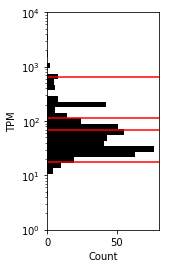

In [136]:
# plot

i = 0
#subset = df_rules[(df_rules.itemset_size>=4)].loc[df_sel.rule_ids[i]].dropna()
tmp = df_rules.loc[df_sel.rule_ids[i]]
subset = dframe_stack_list(tmp,'items_gene_id')
subset['ytpm'] = dframe_stack_list(tmp,'ytpm').ytpm.values

plt.figure(figsize=(2,4))
bmin, bmax = 1, 10000
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
plt.hist(subset.ytpm,bins = logbins,color='k',orientation="horizontal")
plt.yscale('log')
plt.ylim(bmin,bmax)
plt.ylabel('TPM')
plt.xlabel('Count')
for idx,g in genes.iterrows():
    plt.plot([0,100],[g.ytpm,g.ytpm],'r')
    #plt.annotate(g['Standard gene name (optional)'],xy=(80,g.ytpm-5),color='r')
plt.xlim(0,80)

#plt.show()
plt.savefig("f4f.svg")


In [137]:
# sanity check num genes
# multiple gene occurrences since we are looking at rules!

i=0
tmp = df_rules.loc[df_sel.rule_ids[i]]
print(len([el for it in tmp.items_gene_id.values for el in it]))
print(len(np.unique([el for it in tmp.items_gene_id.values for el in it])))

i=1
tmp = df_rules.loc[df_sel.rule_ids[i]]
print(len([el for it in tmp.items_gene_id.values for el in it]))
print(len(np.unique([el for it in tmp.items_gene_id.values for el in it])))

481
144
99
42


In [138]:
# get motif positions
# cross search gene_id, items_cluster

tmp = []
for i in range(genes.shape[0]):
    tmp.append(df_seqs[(df_seqs.gene_id==genes.items_gene_id.iloc[i])&
            (df_seqs.cluster.isin(genes.items_cluster.iloc[i]))])
pd.concat(tmp)



,seq_index,region,motif,peak_index,zscores,relevance,Y,Y_bin,Y_pred,Y_pred_bin,Accuracy_bin,gene_id,Y_test,Y_test_bin,seq,cluster
21715,2710,0_promoter,AAAATAGTATT,"(908, 910)","[2.63756316, 2.7186033]",[0.03794467 0.03903942],4.043655,0,4.431476,0,True,YJL194W,4.043655,0,AAAATAGTATT,0_9
21717,2710,0_promoter,TTAGTTAGTCTATT,"(917, 922)","[-2.06012115, -4.54851742, -5.31510899, -4.132...",[-0.02551488 -0.05912985 -0.0694855 -0.053514...,4.043655,0,4.431476,0,True,YJL194W,4.043655,0,TTAGTTAGTCTATT,0_86
39311,2710,1_5UTR,TACCATATACGTTC,"(285, 290)","[4.11121423, 3.9426563, 2.35623286, 2.34499795...",[0.08363941 0.08022336 0.04807242 0.04784473 0...,4.043655,0,4.431476,0,True,YJL194W,4.043655,0,TACCATATACGTTC,1_20
67598,2710,3_terminator,TTTTCTCTTTC,"(7, 9)","[3.46633595, 2.2764228]",[0.04858224 0.03249139],4.043655,0,4.431476,0,True,YJL194W,4.043655,0,TTTTCTCTTTC,3_0
27978,3490,0_promoter,AAAACGTGAAAAAATAAG,"(907, 916)","[2.18366149, 3.17260306, 3.97130967, 5.1329334...",[0.0318945 0.04517944 0.05590886 0.07151353 0...,6.953295,2,6.976822,2,True,YNL207W,6.953295,2,AAAACGTGAAAAAATAAG,0_1
27981,3490,0_promoter,ATATACATATATA,"(846, 850)","[-2.11479806, -2.001174, -2.07188309, -2.05917...",[-0.02584883 -0.02432246 -0.02527233 -0.0251016 ],6.953295,2,6.976822,2,True,YNL207W,6.953295,2,ATATACATATATA,0_86
52817,3490,2_3UTR,GTTATCCATAATTT,"(261, 266)","[2.39450992, 3.10170839, 2.12805779, 2.9462219...",[0.049747 0.06251422 0.04493668 0.05970718 0...,6.953295,2,6.976822,2,True,YNL207W,6.953295,2,GTTATCCATAATTT,2_1
52820,3490,2_3UTR,TGATTTTTAAGC,"(278, 281)","[2.58112703, 2.64166578, 4.05812241]",[0.05311604 0.05420896 0.07978058],6.953295,2,6.976822,2,True,YNL207W,6.953295,2,TGATTTTTAAGC,2_6
71206,3490,3_terminator,TGCTATATTAT,"(0, 2)","[2.16565267, 2.08357695]",[0.01819156 0.017485 ],6.953295,2,6.976822,2,True,YNL207W,6.953295,2,TGCTATATTAT,3_12
362,44,0_promoter,GAAAAAAAGTT,"(969, 971)","[2.13912779, 2.16451791]",[0.02616876 0.02644147],8.392881,2,8.406944,3,False,YGL231C,8.392881,2,GAAAAAAAGTT,0_0


In [139]:
# df_gsa = (rules_fdr[(rules_fdr.itemset_size>1)&(rules_fdr.num_genes>=20)]
#  .sort_values(by='num_genes',ascending=False)
# )
# print(df_gsa.shape)

# # import csv
# for ind,row in df_gsa.iterrows():
#     #print(row.items_gene_name)
# #     with open('glist'+str(ind)+'.csv', 'w') as myfile:
# #         wr = csv.writer(myfile, quoting=csv.QUOTE_NONE)
# #         wr.writerow(list(row.items_gene_name))
#     np.savetxt('glist'+str(ind)+'.csv', list(row.items_gene_name), delimiter=",", fmt='%s')


# Codon frequencies

In [132]:
# Load data
# codon frequencies / probabilites
cp = np.divide(cf,cf.sum(axis=1).reshape((-1,1)))

df_cp = pd.DataFrame(gene_names, columns=['gene_id'])
df_cp['codon_prob'] = [xx for xx in cp]

bin_edges = [0, .25, .5, .75, 1.]
labels = [0,1,2,3]   
Y_q = np.array(pd.qcut(Y.reshape((-1,)),q=bin_edges,labels=labels, retbins=False))
print(Y_q.shape)
df_cp['quartile'] = Y_q
df_cp.head()


(4238,)


,gene_id,codon_prob,quartile
0,YLR410W,"[0.05492589363557106, 0.02964254577157803, 0.0...",3
1,YMR177W,"[0.03522504892367906, 0.023483365949119372, 0....",0
2,YGL201C,"[0.022593320235756387, 0.018664047151277015, 0...",2
3,YNL066W,"[0.0166270783847981, 0.026128266033254157, 0.0...",3
4,YER094C,"[0.009708737864077669, 0.019417475728155338, 0...",3


In [135]:
## Analysis rules v motifs
# instead of expression levels with distance to 
# codon frequencies

def get_distance_codons(df):
    # test euclidean distance
    tmplist = []
    for i in range(df.shape[0]):
        for j in range(i+1,df.shape[0]):
            tmplist.append(spatial.distance.euclidean(df.codon_prob[i],df.codon_prob[j]))
    return np.array(tmplist)

df_names = pd.DataFrame(gene_names,columns=['gene_id'])
df_cp = df_cp.set_index('gene_id')

import time
t0 = time.time()

p_cutoffs = [['All',1],
             ['Significant',0.05],
             ['BH-adjusted',rules_fdr.chi_pval.max()],
             ['Bonferroni',0.05/df_rules.shape[0]]]
df_plot = []
for cut in [p_cutoffs[2]]:
    tmp_rules = filter_rules(df_rules[df_rules.chi_pval<=cut[1]])
    tmp_motifs = filter_motifs(df_motifs, tmp_rules)
    tmp_genes = filter_genes(df_cp.reset_index(), tmp_rules)   
    df_plot.append([cut[0],cut[1],
                    tmp_genes.shape[0],
                    tmp_motifs.shape[0],
                    tmp_rules.shape[0],
                    tmp_genes.apply(lambda x: np.median(get_distance_codons(x)),axis=1).values,
                    tmp_motifs
                    .apply(lambda x: np.median(get_distance_codons(df_cp.loc[df_names.loc[x.genes].gene_id])),axis=1)
                    .values,
                    tmp_rules
                    .apply(lambda x: np.median(get_distance_codons(df_cp.loc[x.items_gene_id])),axis=1)
                    .values,
                    tmp_genes.apply(lambda x: np.var(get_distance_codons(x)),axis=1).values,
                    tmp_motifs
                    .apply(lambda x: np.var(get_distance_codons(df_cp.loc[df_names.loc[x.genes].gene_id])),axis=1)
                    .values,
                    tmp_rules
                    .apply(lambda x: np.var(get_distance_codons(df_cp.loc[x.items_gene_id])),axis=1)
                    .values
                    ])

df_plot = pd.DataFrame(df_plot,columns=['subset','p_cutoff',
                                        'genes','motifs','rules',
                                        'median_genes','median_motifs','median_rules',
                                        'var_genes','var_motifs','var_rules'])

print(time.time()-t0)


524.0079295635223


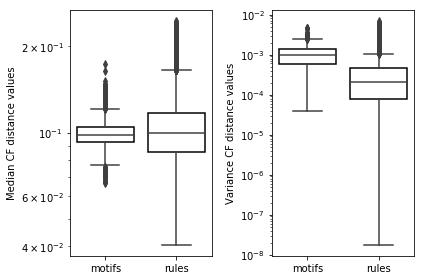

In [136]:
# plot
# long df 
# type, value range, value var

df_tmp = (dframe_stack_list(df_plot.
            melt(id_vars=['subset'],value_vars=['median_motifs','median_rules']),
                          'value')
            .rename(columns={'value':'median'})
         )
df_tmp['var'] = dframe_stack_list(df_plot.
            melt(id_vars=['subset'],value_vars=['var_motifs','var_rules']),
                          'value')['value']
df_tmp['type'] = (df_tmp
                      .variable
                      .apply(lambda x: x.split('_')[1])
                     )
df_tmp = df_tmp.melt(id_vars=['subset','type'],value_vars=['median','var'])
df_tmp.head()

mpl.rcParams['figure.dpi'] = 90
f2 = plt.figure(figsize=(6,4))
plt.subplot(1,2,1)
tmp = df_tmp[(df_tmp.subset=='BH-adjusted')&(df_tmp.variable=='median')]
ax = sns.boxplot(data=tmp,x='type',y='value')
plt.yscale('log')
plt.ylabel('Median CF distance values')
plt.xlabel('')
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

plt.subplot(1,2,2)
tmp = df_tmp[(df_tmp.subset=='BH-adjusted')&(df_tmp.variable=='var')]
ax = sns.boxplot(data=tmp,x='type',y='value')
plt.yscale('log')
plt.ylabel('Variance CF distance values')
plt.xlabel('')
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

plt.tight_layout()
plt.show()

In [137]:
print(np.var(df_plot.median_rules[0])/np.var(df_plot.median_motifs[0]))
print(np.median(df_plot.var_motifs[0])/np.median(df_plot.var_rules[0]))

6.455201784246557
4.890738667758601


In [138]:
# significance testing
# diff var median and median var
print(np.var(df_plot.median_rules.values[0])/np.var(df_plot.median_motifs.values[0]))
pval_median = between_pval(df_plot,'p_cutoff','median_motifs','median_rules','var') 
print(pval_median)

print(1/(np.median(df_plot.var_rules.values[0])/np.median(df_plot.var_motifs.values[0])))
pval_var = between_pval(df_plot,'p_cutoff','var_motifs','var_rules','mean') 
print(pval_var)


6.455201784246557
   p_cutoff           pval
0   0.00304  2.549182e-114
4.890738667758602
   p_cutoff  pval
0   0.00304   0.0
